In [16]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [17]:
rcParams['figure.dpi']=100
rcParams['figure.figsize']=(7,5)

In [545]:
from scipy import constants as c
from scipy.integrate import quad
from scipy.linalg import null_space
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import gaussian_filter1d as gf1
from scipy import constants as c
from scipy.special import genlaguerre
from scipy.interpolate import UnivariateSpline
import numba as nb
import numba_scipy

# Functions used throughout the notebook

In [19]:
# Fermi-Dirac distribution, E and µ in µeV, T in K
def fdd(E, T, mu=0):
    return 1/(exp((E-mu)*c.e*1e-6/c.k/T)+1)

# Function converts V to K
def eVtoK(V):
    return V*c.e/c.k

# Function coverts K to µeV
def toueV(T):
    return T*c.k/c.e*1e6

# Dynes density of states, all parameters should be in same units
def dynesDOS(E, dyn, delta):
    return abs(real((E+1j*dyn)/(sqrt((E+1j*dyn)**2-delta**2))))

In [20]:
# Semi-optimized SIS IV
# Delta, dynes parameter, and voltage is in µV, temperatures are in K, resistance in Ohm
# Function returns current in A
# Voltage points need to be multiples of integration points (E), i.e. if v is spaced by 0.5 µV, de= 0.25, or 0.125, but not 0.4 or 0.2 
def fast_SIS_IV(v,delta1, dyn1, T1, delta2, dyn2, T2, R):
    de = 0.5
    maxv = math.ceil(max(abs(v))/de)*de
    maxe = max(2*maxv, 5*deltaAl)
    E = arange(-maxe-maxv, maxe+maxv, de)
    mask = logical_and(E > -maxe, E < maxe)
    offset = int_((v/de).reshape(len(v), 1))
    dos2 = dynesDOS(E[mask], dyn2, delta2)
    fermi2 = fdd(E, T2)
    dos1 = dynesDOS(E[mask], dyn1, delta1)
    fermi1 = fdd(E[mask], T2)
    curr = empty(len(v))
    T = max(T1,T2)
    for i in range(len(v)):
        dos2rolled = roll(dos2, offset[i])
        fermi2rolled = roll(fermi2, offset[i])
        if v[i] < 0:
             maskv = logical_and(E[mask]>v[i]-13*c.k*T/c.e*1e6, E[mask]<+13*c.k*T/c.e*1e6)
        if v[i] >= 0:
             maskv = logical_and(E[mask]<v[i]+13*c.k*T/c.e*1e6, E[mask]>-13*c.k*T/c.e*1e6)
        curr[i] = trapz(dos2rolled[maskv]*dos1[maskv]*(fermi2rolled[mask][maskv]-fermi1[maskv]))*de/R*1e-6
    return curr

In [21]:
# Semi-optimized SIN IV
# Delta, dynes parameter, and voltage is in µV, temperatures are in K, resistance in Ohm
# Function returns current in A
# Voltage points need to be multiples of integration points (E), i.e. if v is spaced by 0.5 µV, de= 0.25, or 0.125, but not 0.4 or 0.2 
def fast_SIN_IV(v,delta1, dyn1, T1, T2, R):
    de = 0.05
    maxv = math.ceil(max(abs(v))/de)*de
    maxe = max(2*maxv, 5*deltaAl)
    E = arange(-maxe-maxv, maxe+maxv, de)
    mask = logical_and(E > -maxe, E < maxe)
    offset = int_((v/de).reshape(len(v), 1))
    fermi2 = fdd(E, T2)
    dos1 = dynesDOS(E[mask], dyn1, delta1)
    fermi1 = fdd(E[mask], T1)
    curr = empty(len(v))
    T = max(T1,T2)
    for i in range(len(v)):
        fermi2rolled = roll(fermi2, offset[i])
        if v[i] < 0:
             maskv = logical_and(E[mask]>v[i]-13*c.k*T/c.e*1e6, E[mask]<+13*c.k*T/c.e*1e6)
        if v[i] >= 0:
             maskv = logical_and(E[mask]<v[i]+13*c.k*T/c.e*1e6, E[mask]>-13*c.k*T/c.e*1e6)
        curr[i] = trapz(dos1[maskv]*(fermi2rolled[mask][maskv]-fermi1[maskv]))*de/R*1e-6
    return curr

In [909]:
def RateSISIS(E, dE, dyn, delta, Tn, Ts):
    return  dynesDOS(E-dE, dyn, delta)*dynesDOS(E, dyn, delta)*(1-fdd(E, Tn))*fdd(E-dE, Ts)

In [32]:
def RateSINIS(E, dE, dyn, delta, Tn, Ts):
    return  dynesDOS(E-dE, dyn, delta)*(1-fdd(E, Tn))*fdd(E-dE, Ts)

In [23]:
def alphanl(n,l,lbda):
    c = arange(n+1,n+l+1,dtype=float)
    rho = lbda**2
    anl = 1/(prod(c)) * exp(-rho) * lbda**(2*l) * (genlaguerre(n,l)(rho))**2
    return anl

In [24]:
def generateLaguerrearray(nl, λ):
    Laguerrearr = zeros((nl, nl))
    for i in range(nl):
        for j in range(nl):
            Laguerrearr[i,j] = alphanl(i,j,λ)
    return Laguerrearr

## Dynes DOS tests

Text(0, 0.5, 'DOS')

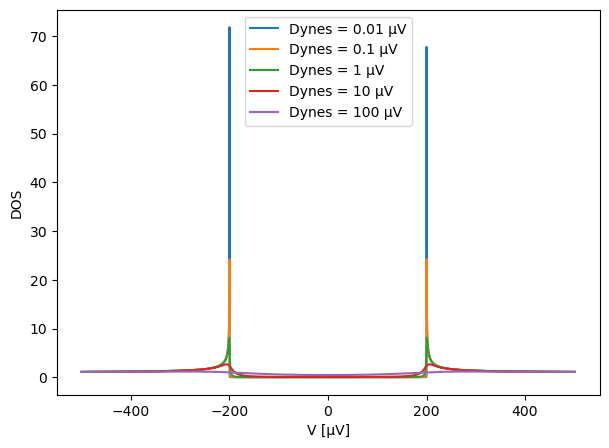

In [25]:
E = linspace(-500,501,9000)
delAl = 200
dynlist = [0.01, 0.1, 1, 10, 100]
for d in dynlist:
    plot(E,dynesDOS(E,d,delAl), label = f'Dynes = {d} µV')
legend()
xlabel('V [µV]')
ylabel('DOS')

## Fermi-Dirac tests

Text(0.5, 0, 'E [uV]')

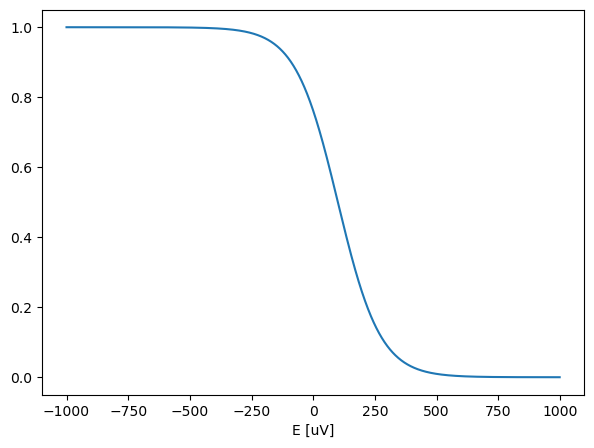

In [26]:
T=1
E = arange(-1000,1000, 1)
plot(E, fdd(E,T, 100))
xlabel('E [uV]')

## Semi-optimized SIS IV

CPU times: total: 250 ms
Wall time: 248 ms


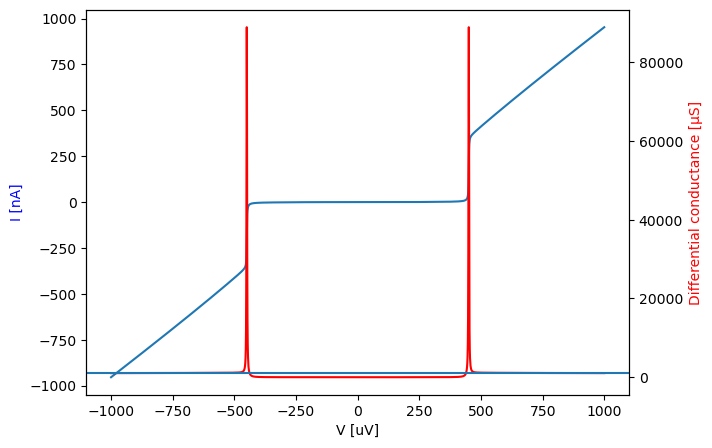

In [27]:
%%time
v = arange(-1000, 1000, 1)
deltaAl = 200
dynAl = 0.1
deltaGrAl = 250
dynGrAl = 1
T1 = 0.05
T2 = 0.05
R = 1e3
curr = fast_SIS_IV(v, deltaAl, dynAl, T1, deltaGrAl, dynGrAl, T2, R)
plot(v,curr*1e9)
xlabel('V [uV]')
ylabel('I [nA]', color = 'blue')
ax = gca()
ax1 = ax.twinx()
ax1.plot(v,gradient(curr*1e9, mean(diff(v)))*1e3, color = 'red')
ax1.set_ylabel('Differential conductance [µS]', color = 'red')
ax1.axhline(1e3)

## Semi-optimized SIN IV 

CPU times: total: 875 ms
Wall time: 865 ms


Text(0, 0.5, 'Differential conductance [µS]')

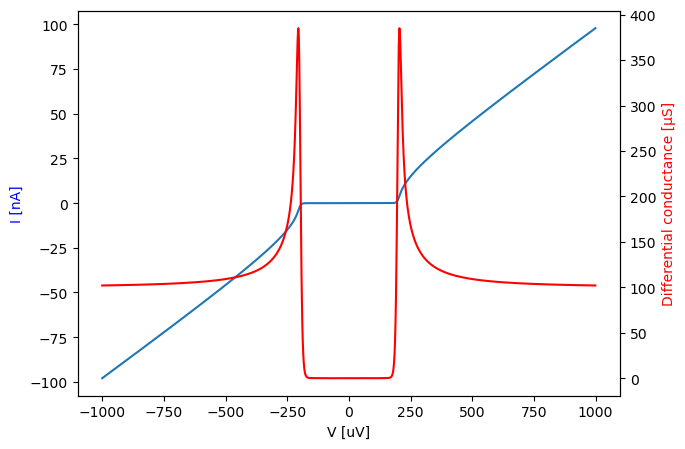

In [28]:
%%time
v = arange(-1000, 1000, 1)
deltaAl = 200
dynAl = 0.1
deltaGrAl = 250
dynGrAl = 1
T1 = 0.05
T2 = 0.05
R = 10e3
curr = fast_SIN_IV(v, deltaAl, dynAl, T1, T2, R)
plot(v,curr*1e9)
xlabel('V [uV]')
ylabel('I [nA]', color = 'blue')
ax = gca()
ax1 = ax.twinx()
ax1.plot(v,gradient(curr*1e9, mean(diff(v)))*1e3, color = 'red')
ax1.set_ylabel('Differential conductance [µS]', color = 'red')

# N <-> S tunneling

In [29]:
# Semi-optimized SIN IV
# Delta, dynes parameter, and voltage are in µV, temperatures are in K, resistance in Ohm
# Function returns current in A
# Voltage points need to be multiples of integration points (E), i.e. if v is spaced by 0.5 µV, de= 0.25, or 0.125, but not 0.4 or 0.2 
def SIN_rate(v,delta1, dyn1, T1, T2, R):
    de = 0.1
    maxv = math.ceil(max(abs(v))/de)*de
    maxe = max(2*maxv, 5*deltaAl)
    E = arange(-maxe-maxv, maxe+maxv, de)
    mask = logical_and(E > -maxe, E < maxe)
    offset = int_((v/de).reshape(len(v), 1))
    fermi2 = fdd(E, T2)
    dos1 = dynesDOS(E[mask], dyn1, delta1)
    fermi1 = fdd(E[mask], T1)
    curr = empty(len(v))
    gammans = empty(len(v))
    gammasn = empty(len(v))
    T = max(T1,T2)
    for i in range(len(v)):
        fermi2rolledp = roll(fermi2, offset[i])
        #fermi2rolledm = roll(fermi2, -offset[i])
        if v[i] < 0:
             maskv = logical_and(E[mask]>v[i]-20*c.k*T/c.e*1e6, E[mask]<+20*c.k*T/c.e*1e6)
        if v[i] >= 0:
             maskv = logical_and(E[mask]<v[i]+20*c.k*T/c.e*1e6, E[mask]>-20*c.k*T/c.e*1e6)
        gammans[i] = trapz(dos1*fermi2rolledp[mask]*(1-fermi1))*de
        #gammasn[i] = trapz(dos1*(1-fermi2rolledm[mask])*(fermi1))*de
    return gammans

20.181770646174055
10.54956192868189
5.157563609577814
CPU times: total: 1.59 s
Wall time: 1.63 s


Text(0.5, 1.0, 'Maisi Thesis, figure 2.3 (b)')

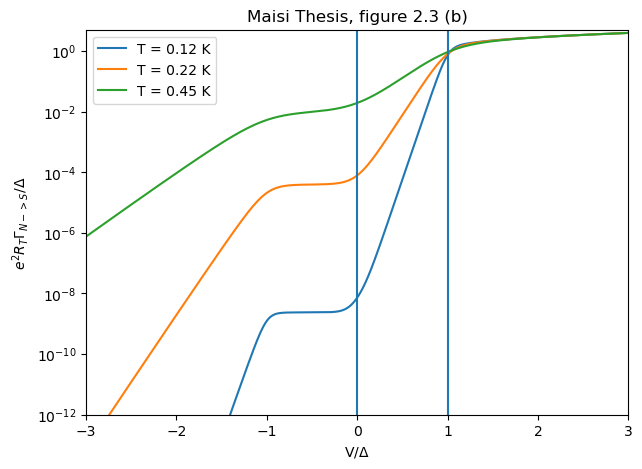

In [30]:
%%time
vsnrate = arange(-1000, 1000, 1)
deltaAl = 200
dynAl = 1e-5
Tlist = [0.115, 0.22, 0.45]
#Tlist = [0.115]
R = 100e3
for T in Tlist:
    print(deltaAl/toueV(T))
    nsnew = SIN_rate(vsnrate, deltaAl, dynAl, T, T, R)
    plot(vsnrate/deltaAl,nsnew/deltaAl, label = f'T = {T:1.2f} K')
legend()
xlim(-3,3)
semilogy()
ylim(1e-12,5)
xlabel('V/$\Delta$')
ylabel('$e^2R_T\Gamma_{N->S}/\Delta$')
axvline(0)
axvline(1)
title('Maisi Thesis, figure 2.3 (b)')

(-1.7, 1.7)

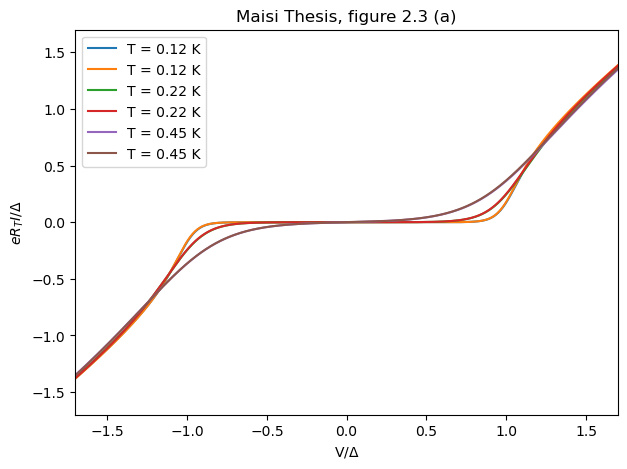

In [31]:
Tlist = [0.115, 0.22, 0.45]
R = 100e3
dynAl = 1e-2
for T in Tlist:
    siniv = fast_SIN_IV(v, deltaAl, dynAl, T, T, R)
    ns = SIN_rate(v, deltaAl, dynAl, T, T, R)
    plot(v/deltaAl, (siniv)/deltaAl*R*1e6, label = f'T = {T:1.2f} K')
    plot(v/deltaAl, (ns-flip(ns))/deltaAl, label = f'T = {T:1.2f} K')
legend()
xlabel('V/$\Delta$')
ylabel('$eR_TI/\Delta$')
title('Maisi Thesis, figure 2.3 (a)')
xlim(-1.7,1.7)
ylim(-1.7,1.7)

# SINIS master equation

- Ben Turek thesis sign convention

In [33]:
dyn = 1e-1
deltaAl = 200
Ts = 0.03
Tn = 0.03

tryparams = (dyn, deltaAl, Tn, Ts)

In [34]:
%%time
maxe = 5000
de = 0.25
vn = arange(-50, deltaAl+50, 1)
v = r_[arange(-1000, -50, 5), vn, arange(deltaAl+50, 1000, 5)]
ratearray = zeros_like(v, dtype = float)
E = arange(-maxe, maxe, de, dtype=float)
for i in range(len(v)):
    ratearray[i] = trapz(RateSINIS(E,v[i],*tryparams))*de
Rateinterp = UnivariateSpline(v, ratearray,k=1, s=0)

C:\Users\stanisavljevic\AppData\Local\Temp\ipykernel_17512\204757762.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(exp((E-mu)*c.e*1e-6/c.k/T)+1)


CPU times: total: 2.12 s
Wall time: 2.13 s


(1e-15, 200.0)

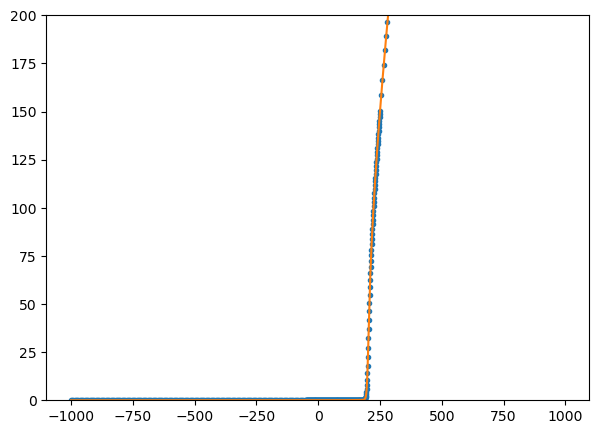

In [35]:
plot(v, ratearray, '.')
plot(v, Rateinterp(v))
#semilogy()
ylim(1e-15, 200)

In [36]:
def Gsn1(Ec, n, ng, v, κ, R):
    return Rateinterp(-(2*Ec*(1/2+(n-ng))+κ*v))*1e3/((κ)*R)
def Gns1(Ec, n, ng, v, κ, R):
    return Rateinterp(-(2*Ec*(1/2-(n-ng))-κ*v))*1e3/((κ)*R)
def Gsn2(Ec, n, ng, v, κ, R):
    return Rateinterp(-(2*Ec*(1/2+(n-ng))-κ*v))*1e3/((κ)*R)
def Gns2(Ec, n, ng, v, κ, R):
    return Rateinterp(-(2*Ec*(1/2-(n-ng))+κ*v))*1e3/((κ)*R)
def Gm(Ec, n, ng, v, κ1, κ2, R):
    return Gns1(Ec, n, ng, v, κ1, R) + Gns2(Ec, n, ng, v, κ2, R)
def Gp(Ec, n, ng, v, κ1, κ2, R):
    return Gsn1(Ec, n, ng, v, κ1, R) + Gsn2(Ec, n, ng, v, κ2, R)

In [37]:
%%time
Ec = 133
v = arange(-1500,1500,0.2)
n = arange(-5,6)
κ1 = 0.7
κ2 = 0.3
R = 700e3
ng=0
curr1junc = zeros((len(v), len(n)))
Gmatrix = zeros((len(v), len(n), len(n)))
for i, nrow in enumerate(n):
    for j, ncol in enumerate(n):
        if nrow == ncol:
            Gmatrix[:, i, j] = - Gm(Ec, nrow, ng, v, κ1, κ2, R) - Gp(Ec, nrow, ng, v, κ1, κ2, R)
        elif j - i == 1:
            Gmatrix[:, i, j] = Gm(Ec, ncol, ng, v, κ1, κ2, R)
        elif j - i == - 1:
            Gmatrix[:, i, j] = Gp(Ec, ncol, ng, v, κ1, κ2, R)
        else:
            Gmatrix[:,i,j] = 0
    curr1junc[:,i] = (Gsn1(Ec, nrow, ng, v, κ1, R)-Gns1(Ec, nrow, ng, v, κ1, R))
Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gm(Ec, n[0], ng, v, κ1, κ2, R)
Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gp(Ec, n[-1], ng, v, κ1, κ2, R)
#Gmatmasked = Gmat[maskv,:,:]

CPU times: total: 31.2 ms
Wall time: 35 ms


(-1.0, 1.0)

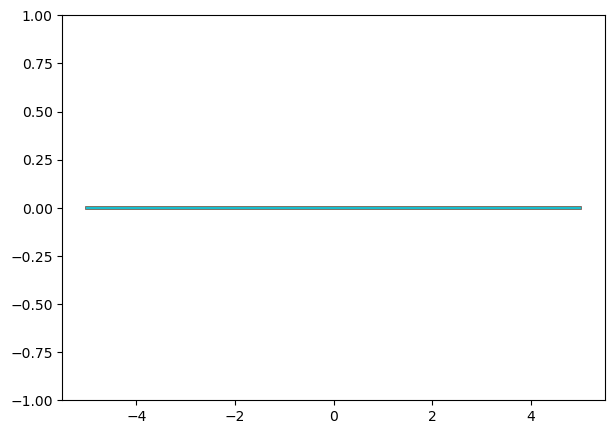

In [38]:
for i in range(len(v)):
    if i%100 ==0:
        plot(n,Gmatrix[i,:,:].sum(0))
ylim(-1,1)

In [39]:
Σ = zeros((11,11))
Σ[0] = ones(11)
svec = zeros(11)
ϵ = 1e-5
svec[0] = ϵ
probn = zeros((len(v),11))
for i in range(len(v)):
    probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    #probn[i,:] = abs(null_space(Gmatmasked[i,:,:]).flatten()/sum(null_space(Gmatmasked[i,:,:]).flatten()))

Text(0, 0.5, 'Probability')

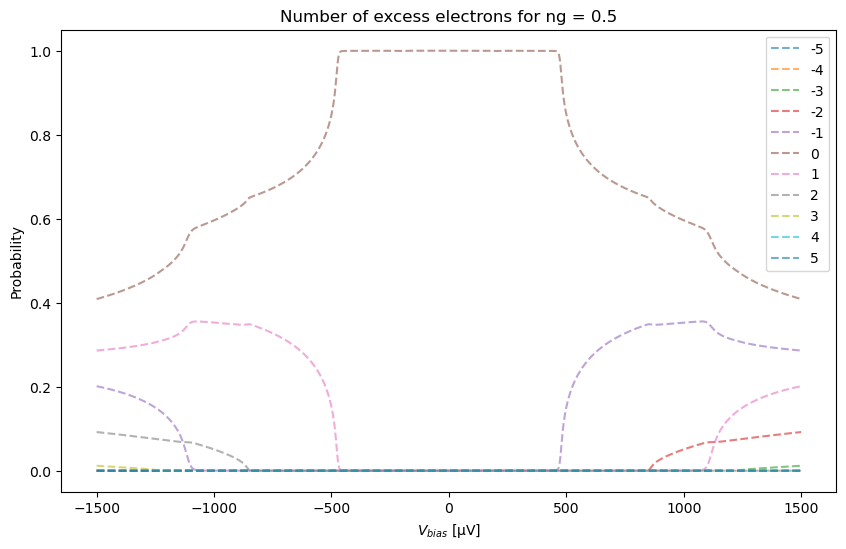

In [40]:
figure(figsize = (10,6))
for i in range(11):
    plot(v, probn[:,i], '--', alpha = 0.6,label = str(n[i]))
legend()
title('Number of excess electrons for ng = 0.5')
xlabel('$V_{bias}$ [µV]')
ylabel('Probability')
#savefig('Nng0p5.png')

In [41]:
#curr1 = currfast
currfast = zeros_like(v)
for i in range(len(v)):
    currfast[i] = -sum(probn[i,:]*curr1junc[i,:])

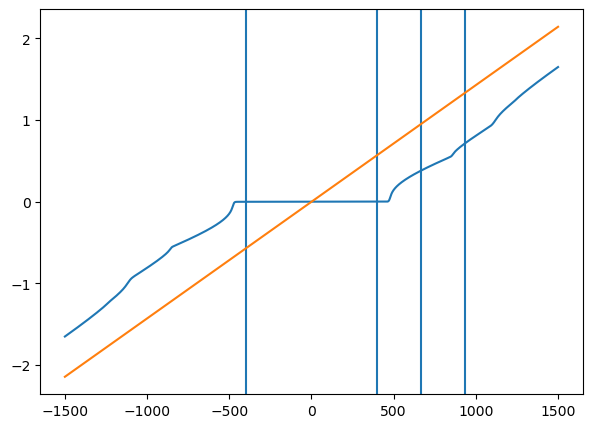

In [42]:
plot(v,currfast)
axvline(400)
axvline(-400)
axvline(400+266)
axvline(400+2*266)
plot(v, v*1e-6/R*1e9)

## ng dependence

In [43]:
v = arange(-1500,1500,1)
n = arange(-5,6)
κ1 = 0.7
κ2 = 0.3
R=700e3
nglist = arange(-1.6,1.61,0.01)
currfastng = zeros((len(nglist), len(v)))
for k, ng in enumerate(nglist):
    curr1junc = zeros((len(v), len(n)))
    Gmatrix = zeros((len(v), len(n), len(n)))
    for i, nrow in enumerate(n):
        for j, ncol in enumerate(n):
            if nrow == ncol:
                Gmatrix[:, i, j] = - Gm(Ec, nrow, ng, v, κ1, κ2, R) - Gp(Ec, nrow, ng, v, κ1, κ2, R)
            elif j - i == 1:
                Gmatrix[:, i, j] = Gm(Ec, ncol, ng, v, κ1, κ2, R)
            elif j - i == - 1:
                Gmatrix[:, i, j] = Gp(Ec, ncol, ng, v, κ1, κ2, R)
            else:
                Gmatrix[:,i,j] = 0
        curr1junc[:,i] = -(Gsn2(Ec, nrow, ng, v, κ2, R)-Gns2(Ec, nrow, ng, v, κ2, R))
    Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gm(Ec, n[0], ng, v, κ1, κ2, R)
    Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gp(Ec, n[-1], ng, v, κ1, κ2, R)
    Σ = zeros((11,11))
    Σ[0] = ones(11)
    svec = zeros(11)
    ϵ = 1e-5
    svec[0] = ϵ
    probn = zeros((len(v),11))
    for i in range(len(v)):
        probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    for i in range(len(v)):
        currfastng[k,i] = -sum(probn[i,:]*curr1junc[i,:])

Text(0, 0.5, 'Current [nA]')

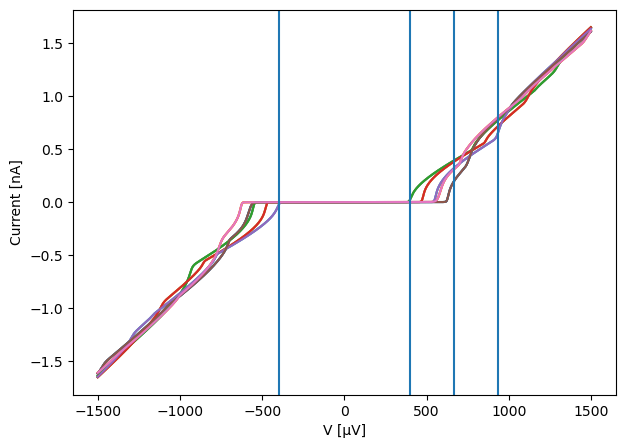

In [44]:
for i in range(len(nglist)):
    if i%20 == 0:
        plot(v, currfastng[i,:], label = str(nglist[i]))
axvline(400)
axvline(-400)
axvline(400+133*2)
axvline(400+133*4)
xlabel('V [µV]')
ylabel('Current [nA]')

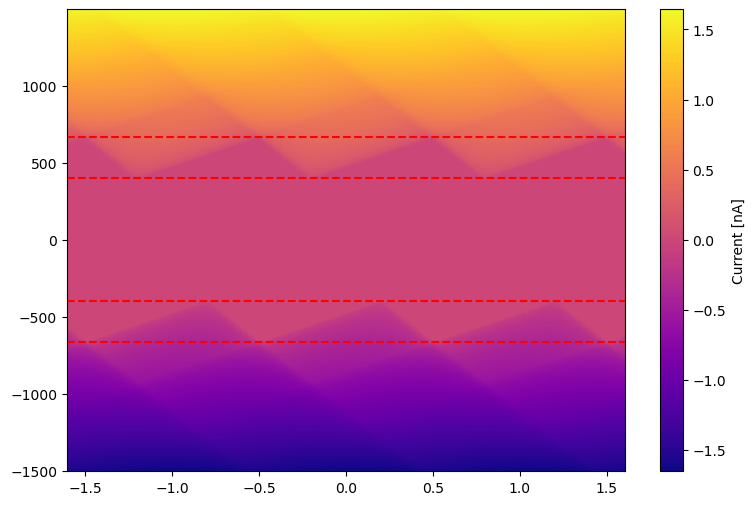

In [45]:
figure(figsize =(9,6))
pcolormesh(nglist,v[::5], currfastng[:,::5].T, cmap ='plasma')
colorbar(label = 'Current [nA]')
axhline(400, color ='red', ls = '--')
axhline(400+2*133, color ='red', ls = '--')
axhline(-400, color ='red', ls = '--')
axhline(-400-2*133, color ='red', ls = '--')

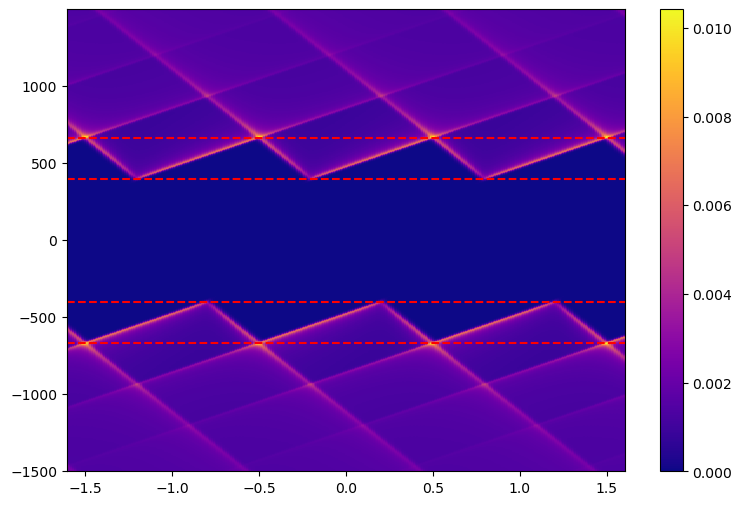

In [47]:
figure(figsize =(9,6))
conductancemap = gradient(currfastng, axis=1)[:,:]
pcolormesh(nglist,v, conductancemap.T, cmap ='plasma')
colorbar()
axhline(400, color ='red', ls = '--')
axhline(400+2*133, color ='red', ls = '--')
axhline(-400, color ='red', ls = '--')
axhline(-400-2*133, color ='red', ls = '--')

# SISIS master equation

In [48]:
dyn = 1e-2
deltaAl = 200
Ts = 0.05
Tn = 0.05
Ec = 133
SISISparams = (dyn, deltaAl, Tn, Ts)

In [49]:
%%time
maxe = 3200
de = 0.02
vn = arange(-20, 2*deltaAl-20, 2)
vn2 = arange(2*deltaAl-20, 2*deltaAl+20, 0.05)
v = r_[arange(-1600, -20, 5), vn, vn2, arange(2*deltaAl+20, 1600, 20)]
ratearr = zeros_like(v, dtype = float)
E = arange(-maxe, maxe, de, dtype=float)
for i in range(len(v)):
    ratearr[i] = trapz(RateSISIS(E,v[i],*SISISparams))*de
Rateinterp = UnivariateSpline(v, ratearr,k=1, s=0)

C:\Users\stanisavljevic\AppData\Local\Temp\ipykernel_17512\204757762.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(exp((E-mu)*c.e*1e-6/c.k/T)+1)


CPU times: total: 1min 33s
Wall time: 1min 34s


In [574]:
vrate = r_[arange(-1600, -20, 5), vn, vn2, arange(2*deltaAl+20, 1600, 20)]
a = interp(vtry, vrate, ratearr)

In [563]:
print(a)
print(Rateinterp(vtry))

3.311780941622799e-07
3.311780941622799e-07


In [579]:
%%time
vtry = 100
for kk in range(1000):
    interp(vtry, vrate, ratearr)


CPU times: total: 31.2 ms
Wall time: 10.5 ms


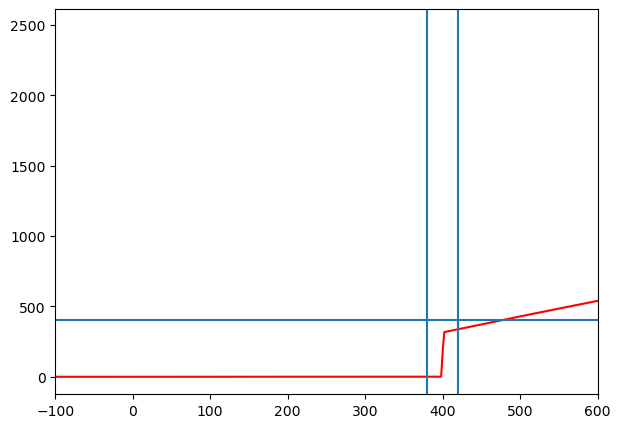

In [572]:
vint = arange(-2000,2500, 2)
#plot(v, ratearr, '.')
plot(vint, Rateinterp(vint), 'r')
#semilogy()
xlim(-100, 600)
#ylim(1e-12, 1e3)
#axvline(400)
axvline(400-20)
axvline(400+20)
axhline(4e2)
#axhline(1e-1)

In [51]:
v = arange(-1600,1600,0.5)
n = arange(-5,6)
κ1 = 0.6
κ2 = 0.4
R = 700e3
juncparams = (v, κ1, κ2, R)
Ec=120
n = arange(-5,6)
nglist = arange(-1.6,1.61,0.01)

In [52]:
%%time
Σ = zeros((11,11))
Σ[0] = ones(11)
svec = zeros(11)
ϵ = 1e-5
svec[0] = ϵ
probn = zeros((len(v),11))
SISIScurrng = zeros((len(nglist), len(v)))
for k, ng in enumerate(nglist):
    curr1junc = zeros((len(v), len(n)))
    Gmatrix = zeros((len(v), len(n), len(n)))
    for i, nrow in enumerate(n):
        for j, ncol in enumerate(n):
            if nrow == ncol:
                Gmatrix[:, i, j] = - Gm(Ec, nrow, ng, *juncparams) - Gp(Ec, nrow, ng, *juncparams)
            elif j - i == 1:
                Gmatrix[:, i, j] = Gm(Ec, ncol, ng, *juncparams)
            elif j - i == - 1:
                Gmatrix[:, i, j] = Gp(Ec, ncol, ng, *juncparams)
            else:
                Gmatrix[:,i,j] = 0
        curr1junc[:,i] = (Gsn1(Ec, nrow, ng, v, κ1, R)-Gns1(Ec, nrow, ng, v, κ1, R))
    Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gm(Ec, n[0], ng, *juncparams)
    Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gp(Ec, n[-1], ng, *juncparams)
    for i in range(len(v)):
        probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    for i in range(len(v)):
        SISIScurrng[k, i] = -sum(probn[i,:]*curr1junc[i,:])

CPU times: total: 33.3 s
Wall time: 33.5 s


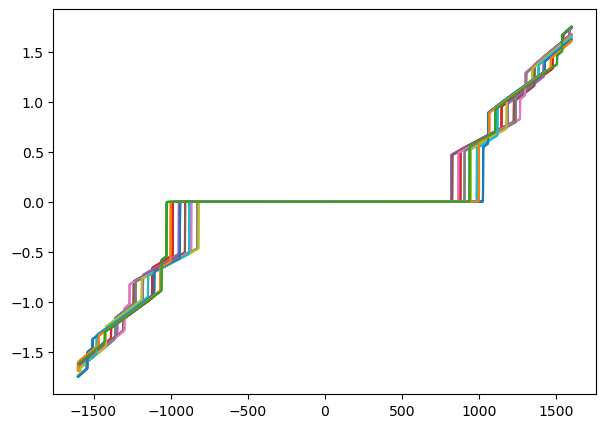

In [53]:
for i in range(len(nglist)):
    if i%10 == 0:
        plot(v, SISIScurrng[i,:], label = str(nglist[i]))
#ylim(-450,450)

(-1.4, 1.2)

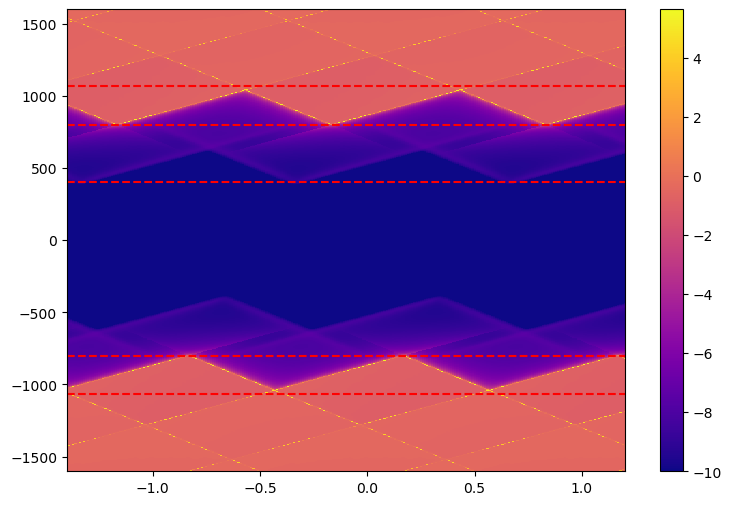

In [54]:
figure(figsize =(9,6))
conductancemap = gradient(SISIScurrng, axis=1)[:,:]
pcolormesh(nglist,v[::5], log(conductancemap[:,::5].T*1000), vmin = -10, cmap ='plasma')
colorbar()
axhline(400, color ='red', ls = '--')
axhline(800, color ='red', ls = '--')
axhline(800+2*133, color ='red', ls = '--')
axhline(-800, color ='red', ls = '--')
axhline(-800-2*133, color ='red', ls = '--')
xlim(-1.4,1.2)

(-1.4, 1.2)

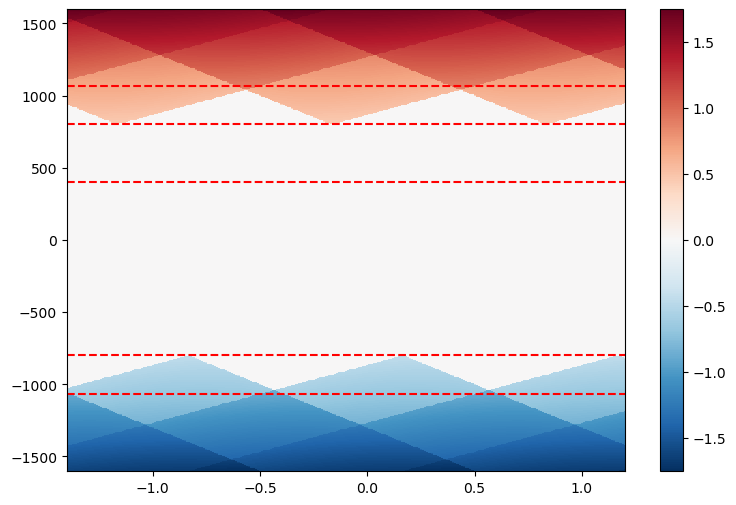

In [57]:
figure(figsize =(9,6))
pcolormesh(nglist,v[::10], gf(SISIScurrng[:,::10], (0.1,0.1)).T, cmap ='RdBu_r')
colorbar()
axhline(400, color ='red', ls = '--')
axhline(800, color ='red', ls = '--')
axhline(800+2*133, color ='red', ls = '--')
axhline(-800, color ='red', ls = '--')
axhline(-800-2*133, color ='red', ls = '--')
xlim(-1.4,1.2)

(900.0, 1000.0)

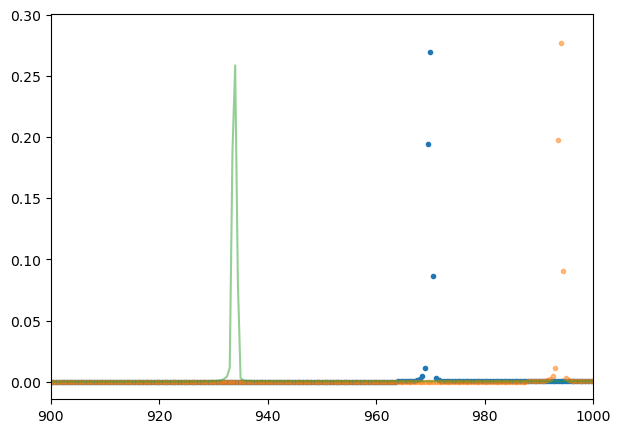

In [58]:
plot(v, conductancemap[15], '.')
plot(v, conductancemap[11], '.', alpha = 0.5)
plot(v, conductancemap[121], alpha = 0.5)
xlim(900,1000)

In [2243]:
def funSISIS(E, dE, dyn, delta, Tn, Ts):
    return  dynesDOS(E-dE, dyn, delta)*dynesDOS(E, dyn, delta)*(1-fdd(E, Tn))*fdd(E-dE, Ts)

def dynesDEVspl(E, dyn, delta):
    return UnivariateSpline(E, gradient(dynesDOS(E,dyn,delAl),E), k=1, s=0)

def fdddev(E, T, mu=0):
    return -exp((E-mu)*c.e*1e-6/c.k/T)/(c.k*T/c.e*1e6*(1+exp((E-mu)*c.e*1e-6/c.k/T))**2)

def fdddevspl(E, T, mu=0):
    return UnivariateSpline(E, gradient(fdd(E,T),E), k=1, s=0)
    
    
#def funSISIScond(E, dE, dyn, delta, Tn, Ts):
    #return dynesDOS(E,dyn,delta)*(1-fdd(E, Tn))*(fdd(E-dE,Ts)*-dynesDEVspl(E, dyn, delta)(E-dE)+fdddev(E-dE, Ts)*dynesDOS(E-dE, dyn, delta))
    
#def funSISIScond(E, dE, dyn, delta, Tn, Ts):
    #return dynesDOS(E,dyn,delta)*(1-fdd(E, Tn))*(fdd(E-dE,Ts)*-dynesDEVspl(E, dyn, delta)(E-dE)+gradient(fdd(E-dE, 0.05),E)*dynesDOS(E-dE, dyn, delta))
    
def funSISIScond(E, dE, dyn, delta, Tn, Ts):
    return dynesDOS(E,dyn,delta)*(1-fdd(E, Tn))*(fdd(E-dE,Ts)*-dynesDEVspl(E, dyn, delta)(E-dE)+fdddevspl(E,T)(E-dE)*dynesDOS(E-dE, dyn, delta))

In [2269]:
dyn = 1e-1
deltaAl = 200
Ts = 0.25
Tn = 0.25
Ec = 133
tryparams = (dyn, deltaAl, Tn, Ts)

In [2303]:
%%time
maxe = 3200
de = 0.0125
v = arange(-1600,1600,1)
cuckotrapzcond = zeros_like(v, dtype = float64)
E = arange(-maxe, maxe, de, dtype=float64)
for i in range(len(v)):
    cuckotrapzcond[i] = trapz(funSISIScond(E,v[i],*tryparams))*de

CPU times: total: 12min 56s
Wall time: 12min 59s


In [2304]:
#Rateinterp = UnivariateSpline(v, cuckotrapz/200,k=1, s=0)
condinterp = UnivariateSpline(v, cuckotrapzcond,k=1, s=0)

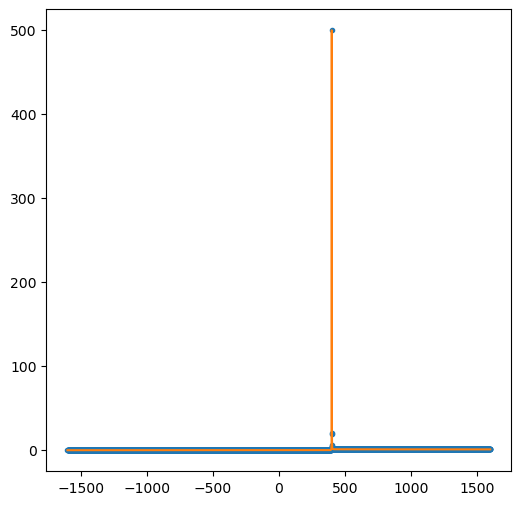

In [2306]:
plot(v, cuckotrapzcond, '.')
plot(v, condinterp(v))
#plot(v, Rateinterp(v))
#semilogy()
#ylim(-0.5, 1)

In [2307]:
Ec = 133
def Gsn1cond(Ec, n, ng, v, κ):
    return condinterp(-(2*Ec*(1/2+(n-ng))+κ*v))
def Gns1cond(Ec, n, ng, v, κ):
    return condinterp(-(2*Ec*(1/2-(n-ng))-κ*v))
def Gsn2cond(Ec, n, ng, v, κ):
    return condinterp(-(2*Ec*(1/2+(n-ng))-κ*v))
def Gns2cond(Ec, n, ng, v, κ):
    return condinterp(-(2*Ec*(1/2-(n-ng))+κ*v))
def Gmcond(Ec, n, ng, v, κ1, κ2):
    return Gns1cond(Ec, n, ng, v, κ1) + Gns2cond(Ec, n, ng, v, κ2)
def Gpcond(Ec, n, ng, v, κ1, κ2):
    return Gsn1cond(Ec, n, ng, v, κ1) + Gsn2cond(Ec, n, ng, v, κ2)

In [2313]:
v = arange(0,1900,1)
n = arange(-5,6)
κ1 = 0.5
κ2 = 0.5
nglist = arange(-1.6,1.605,0.005)
currfastng = zeros((len(nglist), len(v)))
for k, ng in enumerate(nglist):
    curr1junc = zeros((len(v), len(n)))
    Gmatrix = zeros((len(v), len(n), len(n)))
    for i, nrow in enumerate(n):
        for j, ncol in enumerate(n):
            if nrow == ncol:
                Gmatrix[:, i, j] = - Gmcond(Ec, nrow, ng, v, κ1, κ2) - Gpcond(Ec, nrow, ng, v, κ1, κ2)
            elif j - i == 1:
                Gmatrix[:, i, j] = Gmcond(Ec, ncol, ng, v, κ1, κ2)
            elif j - i == - 1:
                Gmatrix[:, i, j] = Gpcond(Ec, ncol, ng, v, κ1, κ2)
            else:
                Gmatrix[:,i,j] = 0
        curr1junc[:,i] = (Gsn1cond(Ec, nrow, ng, v, κ1)-Gns1cond(Ec, nrow, ng, v, κ1))
    Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gm(Ec, n[0], ng, v, κ1, κ2)
    Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gp(Ec, n[-1], ng, v, κ1, κ2)
    Σ = zeros((11,11))
    Σ[0] = ones(11)
    svec = zeros(11)
    ϵ = 1e-5
    svec[0] = ϵ
    probn = zeros((len(v),11))
    for i in range(len(v)):
        probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    for i in range(len(v)):
        currfastng[k,i] = -sum(probn[i,:]*curr1junc[i,:])

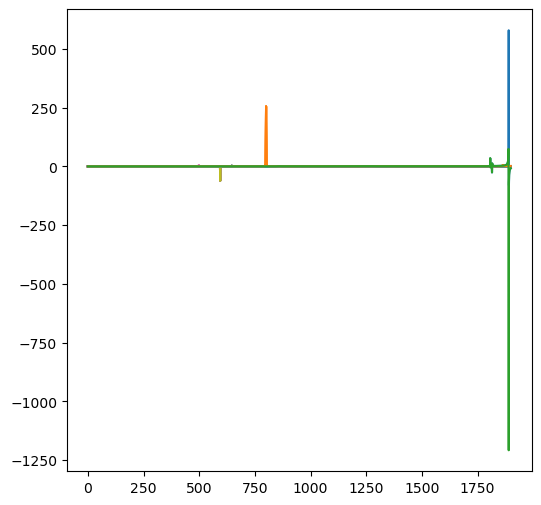

In [2314]:
for i in range(len(nglist)):
    if i%20 == 0:
        plot(v, currfastng[i,:], label = str(nglist[i]))
#axvline(400)
#axvline(-400)
#axvline(400+133*2)
#axvline(400+133*4)
#xlim(-600,600)
#ylim(-5,5)

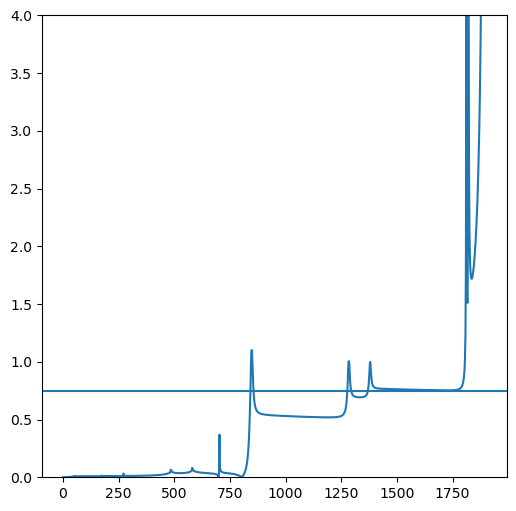

In [2320]:
plot(v, abs(currfastng[2]))
ylim(0,4)
axhline(0.75)

(-1.4, 1.2)

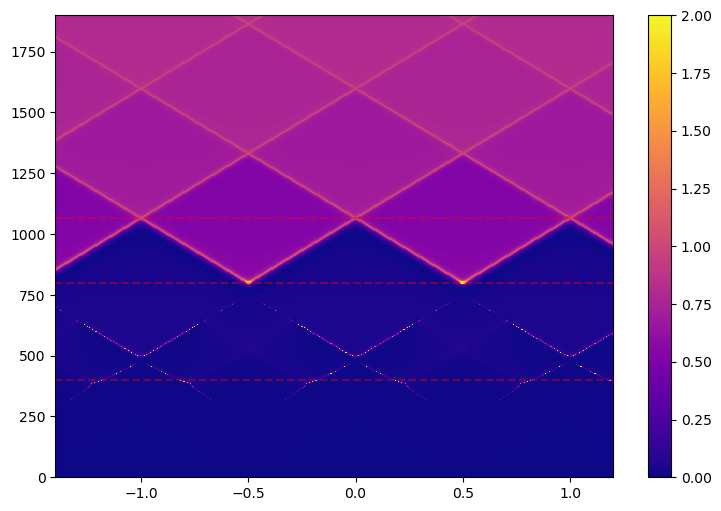

In [2316]:
figure(figsize =(9,6))
#conductancemap = gradient(currfastng, axis=1)[:,:]
pcolormesh(nglist,v, abs(currfastng).T, vmin = 0, vmax = 2, cmap ='plasma')
colorbar()
axhline(400, color ='red', ls = '--', alpha = 0.4)
axhline(800, color ='red', ls = '--', alpha = 0.4)
axhline(800+2*133, color ='red', ls = '--', alpha = 0.4)
#axhline(-800, color ='red', ls = '--', alpha = 0.4)
#axhline(-800-2*133, color ='red', ls = '--', alpha = 0.4)
xlim(-1.4,1.2)

(0.0, 3.0)

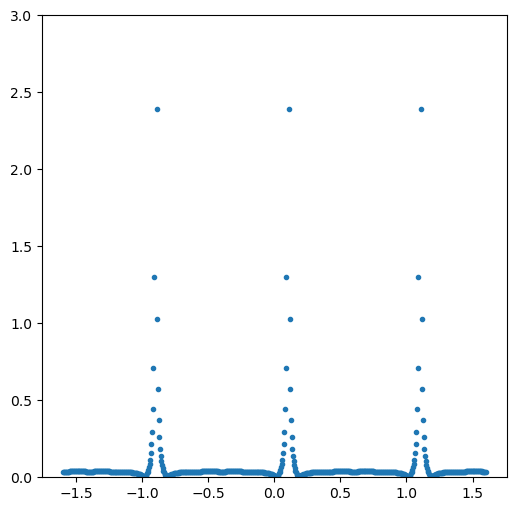

In [2312]:
plot(nglist, abs(currfastng[:,800]), '.')
#plot(v, abs(currfastng[14]), '.', alpha = 0.5)
ylim(0,3)
#axhline(0.7)
#xlim(900,1000)

# Photon-Assisted tunneling

- Computing [$|\omega_{n,l}(\lambda)|^2$ ](https://arxiv.org/abs/1807.02364)

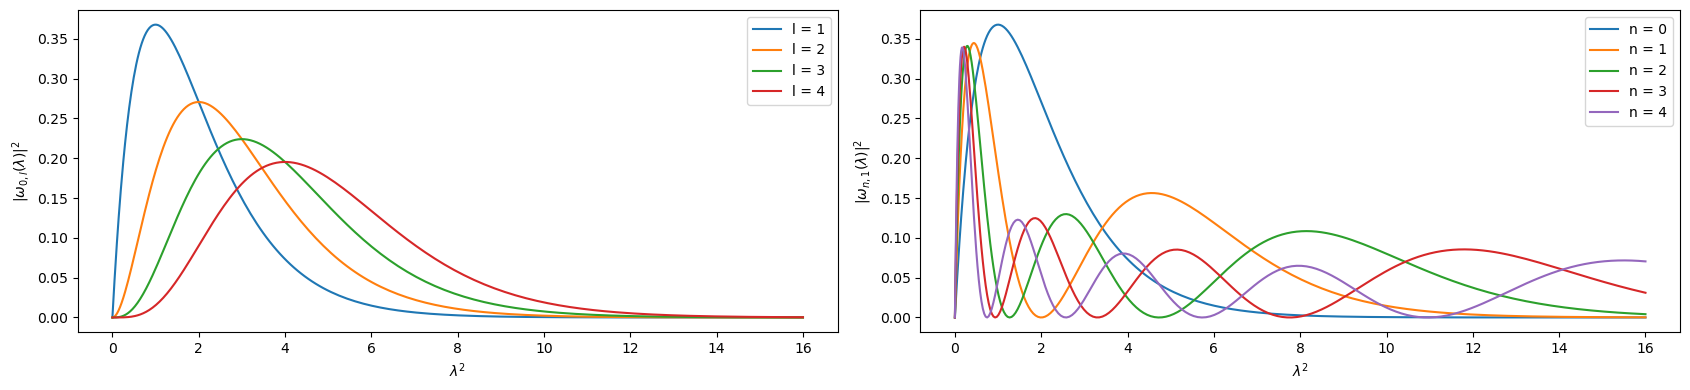

In [59]:
fig, ax = subplots(1, 2, figsize = (17,4))
lbda = linspace(0,4,200)
for i in range(1,5):
    ax[0].plot(lbda**2, alphanl(0,i,lbda), label = f'l = {i}')
#ax[0].plot(lbda**2, exp(-lbda**2), '--')
ax[0].set_xlabel('$\lambda ^2$')
ax[0].set_ylabel('$|\omega_{0,l}(\lambda)|^2$')
ax[0].legend()
for i in range(5):
    ax[1].plot(lbda**2, alphanl(i,1,lbda), label = f'n = {i}')
ax[1].set_xlabel('$\lambda ^2$')
ax[1].set_ylabel('$|\omega_{n,1}(\lambda)|^2$')
ax[1].legend()
tight_layout()

### Tunneling current 

In [66]:
v = arange(0,3500,0.5)
n = arange(-5,6)
κ1 = 0.5
κ2 = 0.5
R=700e3
Ec=80
ng=0.5
curr1junc = zeros((len(v), len(n)))
Gmatrix = zeros((len(v), len(n), len(n)))
for i, nrow in enumerate(n):
    for j, ncol in enumerate(n):
        if nrow == ncol:
            Gmatrix[:, i, j] = - Gm(Ec, nrow, ng, v, κ1, κ2, R) - Gp(Ec, nrow, ng, v, κ1, κ2, R)
        elif j - i == 1:
            Gmatrix[:, i, j] = Gm(Ec, ncol, ng, v, κ1, κ2, R)
        elif j - i == - 1:
            Gmatrix[:, i, j] = Gp(Ec, ncol, ng, v, κ1, κ2, R)
        else:
            Gmatrix[:,i,j] = 0
    curr1junc[:,i] = (Gsn1(Ec, nrow, ng, v, κ1, R)-Gns1(Ec, nrow, ng, v, κ1, R))
Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gm(Ec, n[0], ng, v, κ1, κ2, R)
Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gp(Ec, n[-1], ng, v, κ1, κ2, R)
#Gmatmasked = Gmat[maskv,:,:]

In [67]:
Σ = zeros((11,11))
Σ[0] = ones(11)
svec = zeros(11)
ϵ = 1e-5
svec[0] = ϵ
probn = zeros((len(v),11))
for i in range(len(v)):
    probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    #probn[i,:] = abs(null_space(Gmatmasked[i,:,:]).flatten()/sum(null_space(Gmatmasked[i,:,:]).flatten()))

Text(0, 0.5, 'Probability')

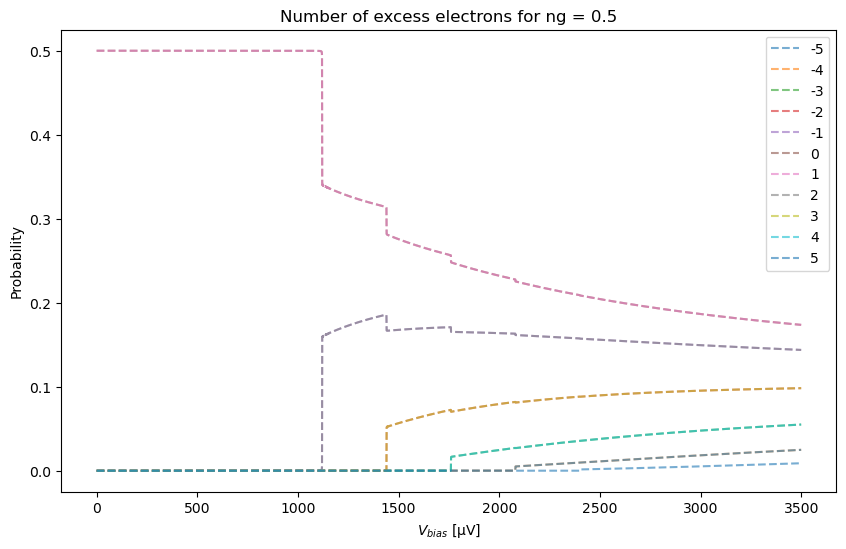

In [68]:
figure(figsize = (10,6))
for i in range(11):
    plot(v, probn[:,i], '--', alpha = 0.6,label = str(n[i]))
legend()
title('Number of excess electrons for ng = 0.5')
xlabel('$V_{bias}$ [µV]')
ylabel('Probability')
#savefig('Nng0p5.png')

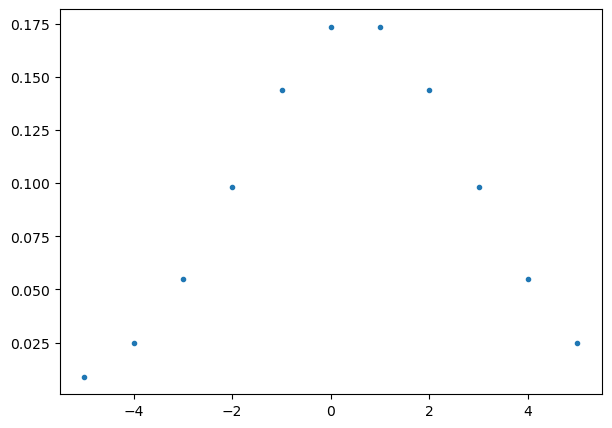

In [69]:
plot(n, probn[-1,:], '.')

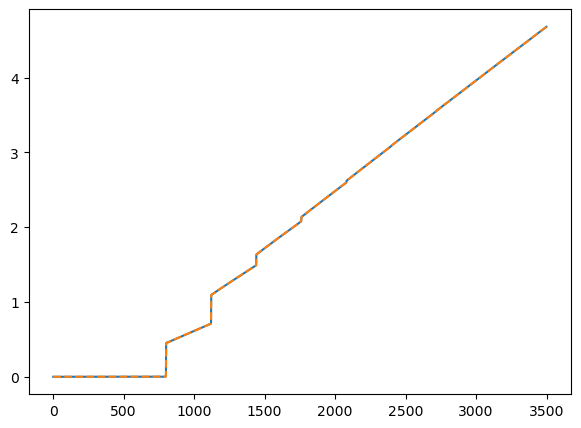

In [70]:
currzerona = zeros_like(v)
for i in range(len(v)):
    currzerona[i] = -sum(probn[i,:]*curr1junc[i,:])
plot(v, currzerona)
czinterp = UnivariateSpline(v, currzerona,k=1, s=0)
plot(v, czinterp(v), '--')

### Photon-assisted current for arbitrary $\lambda$

(500.0, 1200.0)

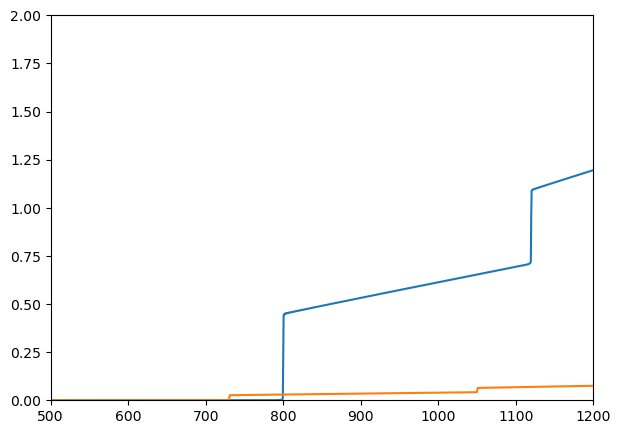

In [74]:
Rk = 25812
Zc = 50
λ = 0.25
f = 16.811e9
v = arange(0,3500,0.5)
plot(v, currzerona)
plot(v, czinterp(v+c.h*f/c.e*1e6)*alphanl(0,1,λ))
#xlim(700,1800)
#axvline(800+266)
ylim(0,2)
xlim(500,1200)

In [75]:
nph = arange(1,10)
phcurr = zeros((len(nph), len(v)))
for kk, np in enumerate(nph):
        for i in range(1,np+1):
             phcurr[kk,:] = phcurr[kk,:] + czinterp(v+i*c.h*f/c.e*1e6)*alphanl(np-i,i,λ)

Text(0.5, 0, 'V [µV]')

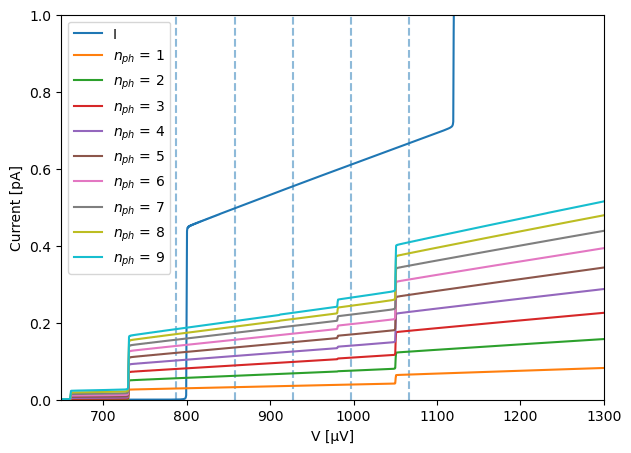

In [76]:
plot(v, currzerona, label = 'I')
axvline(800+266, alpha = 0.5, ls = '--')
axvline(800+266-c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
axvline(800+266-2*c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
axvline(800+266-3*c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
axvline(800+266-4*c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
for kk in range(len(nph)):
    plot(v, phcurr[kk], label = '$n_{ph}$ = '+str(nph[kk]))
xlim(650,1300)
ylim(0,1)
legend()
ylabel('Current [pA]')
xlabel('V [µV]')

# Master equation including the state of the resonator

### For an empty resonator

In [77]:
ntrunc = 5
λ = 0.2
phtry = zeros(len(v))
for i in range(ntrunc+1):
    phtry = phtry + czinterp(v-i*c.h*f/c.e*1e6)*alphanl(1,i,λ)

In [78]:
def blockedGm(v, ntrunc):
    phtry = zeros_like(v)
    for i in range(ntrunc+1):
        phtry = phtry + czinterp(v-i*c.h*f/c.e*1e6)*alphanl(1,i,λ)
    return phtry

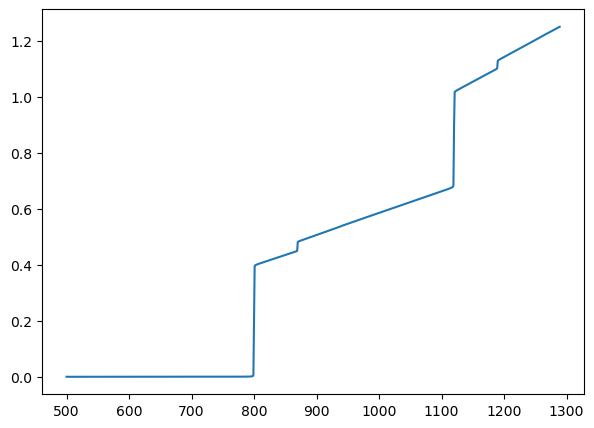

In [79]:
vv = arange(500,1290,1)
plot(vv, blockedGm(vv,5))

In [80]:
def Gsn1phb(Ec, ne, nph, nphem, ng, v, κ, R, f, λ):
    return Rateinterp(-(2*Ec*(1/2+(ne-ng))+κ*(v+nphem*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphem,λ)
def Gns1phb(Ec, ne, nph, nphem, ng, v, κ, R, f, λ):
    return Rateinterp(-(2*Ec*(1/2-(ne-ng))-κ*(v-nphem*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphem,λ)
def Gsn2phb(Ec, ne, nph, nphem, ng, v, κ, R, f, λ):
    return Rateinterp(-(2*Ec*(1/2+(ne-ng))-κ*(v-nphem*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphem,λ)
def Gns2phb(Ec, ne, nph, nphem, ng, v, κ, R, f, λ):
    return Rateinterp(-(2*Ec*(1/2-(ne-ng))+κ*(v+nphem*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphem,λ)
def Gmphb(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f, λ):
    g = zeros_like(v)
    for i in range(ntrunc + 1):
        g += Gns1phb(Ec, ne, nph, i, ng, v, κ1, R, f, λ) + Gns2phb(Ec, ne, nph, i, ng, v, κ2, R, f, λ)
    return g
def Gpphb(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f, λ):
    g = zeros_like(v)
    for i in range(ntrunc + 1):
        g += Gsn1phb(Ec, ne, nph, i, ng, v, κ1, R, f, λ) + Gsn2phb(Ec, ne, nph, i, ng, v, κ2, R, f, λ)
    return g

In [81]:
def Gsn1(Ec, n, ng, v, κ, R):
    return Rateinterp(-(2*Ec*(1/2+(n-ng))+κ*v))*1e3/((κ)*R)

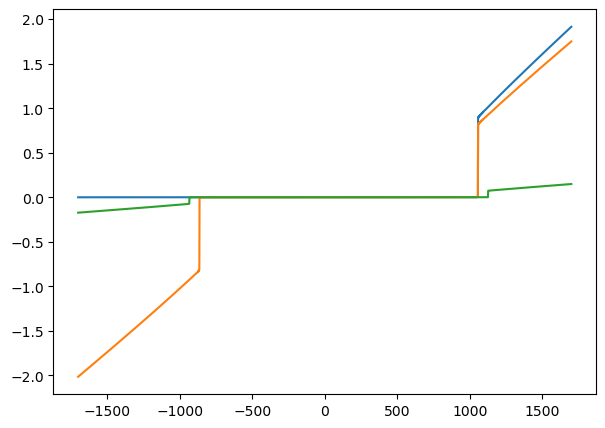

In [83]:
λ = 0.3
v = arange(-1700,1700,0.5)
plot(v, Gns1(Ec, 0, 0.3, v, κ1, R))
plot(v, Gns1phb(Ec, 0, 0, 0, 0.3, v, κ1, R, f, λ)-Gsn1phb(Ec, 0, 0, 0, 0.3, v, κ1, R, f, λ))
plot(v, Gns1phb(Ec, 0, 0, 1, 0.3, v, κ1, R, f, λ)-Gsn1phb(Ec, 0, 0, 1, 0.3, v, κ1, R, f, λ))

In [84]:
λ = 0.7
f = 14.811e9
v = arange(-1700,1700,1, float)
ne = arange(-3,4)
κ1 = 0.5
κ2 = 0.5
R=700e3
nph = 0
ntrunc = 5
Ec=133
ng=0.4
curr1junc = zeros((len(v), len(ne)))
Gmatrix = zeros((len(v), len(ne), len(ne)))
for i, nrow in enumerate(ne):
    for j, ncol in enumerate(ne):
        if nrow == ncol:
            Gmatrix[:, i, j] = - Gmphb(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ) - Gpphb(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
        elif j - i == 1:
            Gmatrix[:, i, j] = Gmphb(Ec, ncol,nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
        elif j - i == - 1:
            Gmatrix[:, i, j] = Gpphb(Ec, ncol, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
        else:
            Gmatrix[:,i,j] = 0
    for kk in range(ntrunc):
        curr1junc[:,i] += (Gsn1phb(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ)-Gns1phb(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ))
Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gmphb(Ec, ne[0], nph,ntrunc, ng, v, κ1, κ2, R, f, λ)
Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gpphb(Ec, ne[-1], nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
#Gmatmasked = Gmat[maskv,:,:]

In [85]:
Σ = zeros((len(ne),len(ne)))
Σ[0] = ones(len(ne))
svec = zeros(len(ne))
ϵ = 1e-5
svec[0] = ϵ
probn = zeros((len(v),len(ne)))
for i in range(len(v)):
    probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    #probn[i,:] = abs(null_space(Gmatmasked[i,:,:]).flatten()/sum(null_space(Gmatmasked[i,:,:]).flatten()))

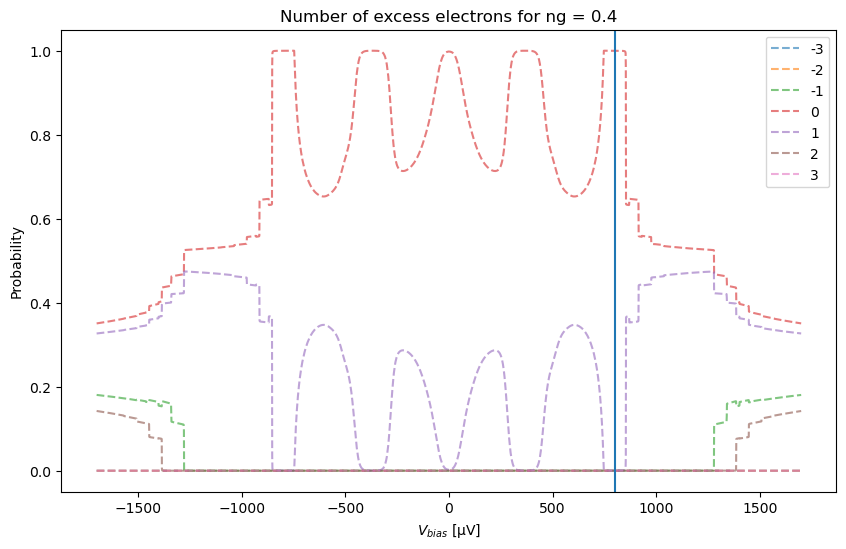

In [86]:
figure(figsize = (10,6))
for i in range(len(ne)):
    plot(v, probn[:,i], '--', alpha = 0.6,label = str(ne[i]))
legend()
title(f'Number of excess electrons for ng = {ng}')
xlabel('$V_{bias}$ [µV]')
ylabel('Probability')
#savefig('Nng0p5.png')
axvline(800)

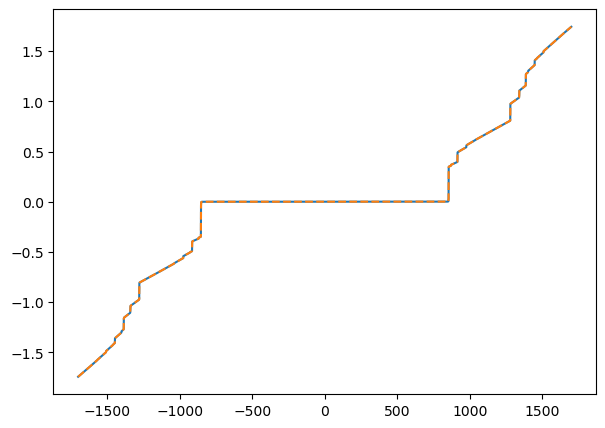

In [87]:
currempty = zeros_like(v)
for i in range(len(v)):
    currempty[i] = -sum(probn[i,:]*curr1junc[i,:])
plot(v, currempty)
czinterp = UnivariateSpline(v, currempty,k=1, s=0)
plot(v, czinterp(v), '--')

### ng dependence

In [88]:
λ = 0.9
f = 14.811e9
v = arange(0,1700,0.5)
ne = arange(-7,8)
κ1 = 0.55
κ2 = 0.45
R=700e3
nph = 0
ntrunc = 5
Ec=80
nglist = arange(-1.6,1.61,0.005)
currblng = zeros((len(nglist), len(v)))
for k, ng in enumerate(nglist):
    curr1junc = zeros((len(v), len(ne)))
    Gmatrix = zeros((len(v), len(ne), len(ne)))
    for i, nrow in enumerate(ne):
        for j, ncol in enumerate(ne):
            if nrow == ncol:
                Gmatrix[:, i, j] = - Gmphb(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ) - Gpphb(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
            elif j - i == 1:
                Gmatrix[:, i, j] = Gmphb(Ec, ncol,nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
            elif j - i == - 1:
                Gmatrix[:, i, j] = Gpphb(Ec, ncol, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
            else:
                Gmatrix[:,i,j] = 0
        for kk in range(ntrunc):
            curr1junc[:,i] += (Gsn1phb(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ)-Gns1phb(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ))
    Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gmphb(Ec, ne[0], nph,ntrunc, ng, v, κ1, κ2, R, f, λ)
    Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gpphb(Ec, ne[-1], nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
    Σ = zeros((len(ne),len(ne)))
    Σ[0] = ones(len(ne))
    svec = zeros(len(ne))
    ϵ = 1e-5
    svec[0] = ϵ
    probn = zeros((len(v),len(ne)))
    for i in range(len(v)):
        probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    for i in range(len(v)):
        currblng[k,i] = -sum(probn[i,:]*curr1junc[i,:])

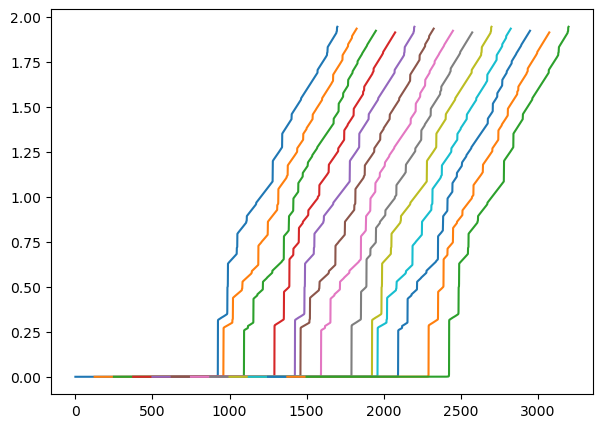

In [89]:
for i in range(len(nglist)):
    if i%50 == 0:
        plot(v+i*2.5, currblng[i,:], label = str(nglist[i]))
#plot(v, v*1e-6/R*0.7*1e9-0.4)

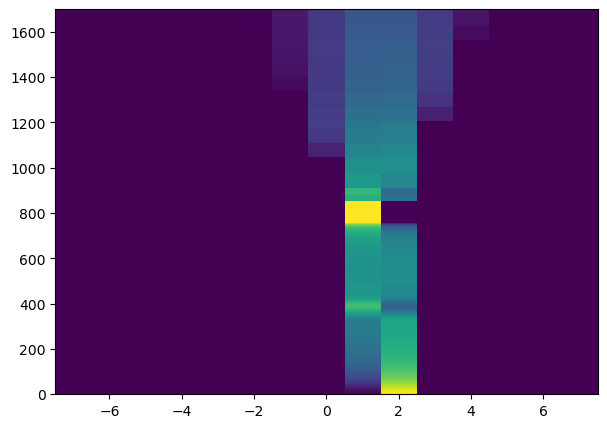

In [90]:
pcolormesh(ne, v, probn)

C:\Users\stanisavljevic\AppData\Local\Temp\ipykernel_17512\261075102.py:1: RuntimeWarning: invalid value encountered in log10
  pcolormesh(nglist, v, log10(gradient((currblng.T)*1e3, axis = 0)), cmap = 'Blues')


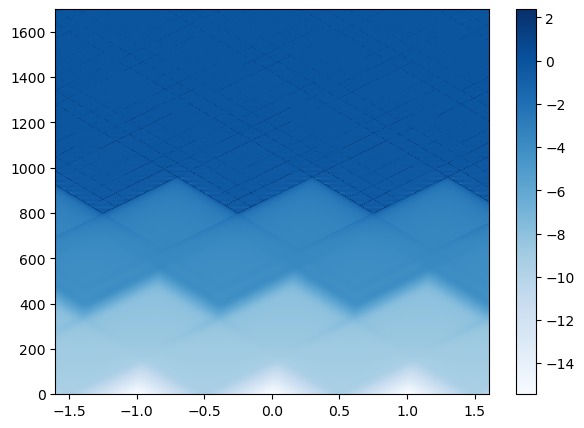

In [92]:
pcolormesh(nglist, v, log10(gradient((currblng.T)*1e3, axis = 0)), cmap = 'Blues')
colorbar()
#ylim(750, 1000)

## Arbitrary fixed resonator fock state

In [96]:
def Gsn1ph(Ec, ne, nph, nphend, ng, v, κ, R, f, λ):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph, nph - nphend, λ)
    else:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphend-nph,λ)
    return rate
def Gns1ph(Ec, ne, nph, nphend, ng, v, κ, R, f, λ):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph, nph - nphend, λ)
    else:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphend-nph,λ)
    return rate
def Gsn2ph(Ec, ne, nph, nphend, ng, v, κ, R, f, λ):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph, nph - nphend, λ)
    else:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphend-nph,λ)
    return rate
def Gns2ph(Ec, ne, nph, nphend, ng, v, κ, R, f, λ):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph, nph - nphend, λ)
    else:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphend-nph,λ)
    return rate
def Gmph(Ec, ne, nph, nphend, ng, v, κ1, κ2, R, f, λ):
    g = Gns1ph(Ec, ne, nph, nphend, ng, v, κ1, R, f, λ) + Gns2ph(Ec, ne, nph, nphend, ng, v, κ2, R, f, λ)
    return g
def Gpph(Ec, ne, nph, nphend, ng, v, κ1, κ2, R, f, λ):
    g = Gsn1ph(Ec, ne, nph, nphend, ng, v, κ1, R, f, λ) + Gsn2ph(Ec, ne, nph, nphend, ng, v, κ2, R, f, λ)
    return g

In [97]:
def Gpphsum(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f, λ):
    g = zeros_like(v)
    for kk in range(ntrunc+1):
        g += Gpph(Ec, ne, nph, kk, ng, v, κ1, κ2, R, f, λ)
    return g
def Gmphsum(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f, λ):
    g = zeros_like(v)
    for kk in range(ntrunc+1):
        g += Gmph(Ec, ne, nph, kk, ng, v, κ1, κ2, R, f, λ)
    return g

In [98]:
ntrunc = 5
nph = 1
f = 4e9
v = arange(-1200,1700, 2, float)
Gmsum  = zeros_like(v)
Gpsum  = zeros_like(v)
for i in range(ntrunc + 1):
    Gmsum += Gmph(Ec, 0, nph, i, 0.5, v, 0.5, 0.5, R, f, 0.8)
    Gpsum += Gpph(Ec, 0, nph, i, 0.5, v, 0.5, 0.5, R, f, 0.8)

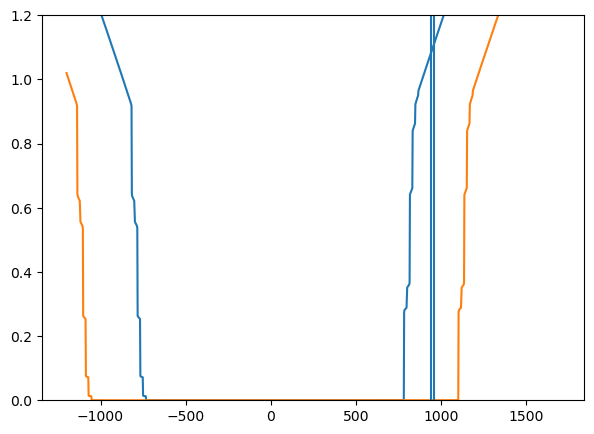

In [99]:
plot(v, Gpsum)
plot(v, Gmsum)
#xlim(700, 1500)
ylim(0,1.2)
axvline(4*200 + 2*Ec - 1*c.h*f/c.e*1e6)
axvline(4*200 + 2*Ec)
#axvline(4*200 + 0*Ec)

In [101]:
λ = 0.1
f = 4.811e9
v = arange(-1700,1700,1, float)
ne = arange(-7,8)
κ1 = 0.5
κ2 = 0.5
R=700e3
nph = 2
ntrunc = nph+5
Ec=203
ng=0.25
curr1junc = zeros((len(v), len(ne)))
Gmatrix = zeros((len(v), len(ne), len(ne)))
for i, nrow in enumerate(ne):
    for j, ncol in enumerate(ne):
        if nrow == ncol:
            Gmatrix[:, i, j] = - Gmphsum(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ) - Gpphsum(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
        elif j - i == 1:
            Gmatrix[:, i, j] = Gmphsum(Ec, ncol,nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
        elif j - i == - 1:
            Gmatrix[:, i, j] = Gpphsum(Ec, ncol, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
        else:
            Gmatrix[:,i,j] = 0
    for kk in range(ntrunc+1):
        curr1junc[:,i] += (Gsn1ph(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ)-Gns1ph(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ))
Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gmphsum(Ec, ne[0], nph,ntrunc, ng, v, κ1, κ2, R, f, λ)
Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gpphsum(Ec, ne[-1], nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
#Gmatmasked = Gmat[maskv,:,:]

In [102]:
Σ = zeros((len(ne),len(ne)))
Σ[0] = ones(len(ne))
svec = zeros(len(ne))
ϵ = 1e-5
svec[0] = ϵ
probn = zeros((len(v),len(ne)))
for i in range(len(v)):
    probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    #probn[i,:] = abs(null_space(Gmatmasked[i,:,:]).flatten()/sum(null_space(Gmatmasked[i,:,:]).flatten()))

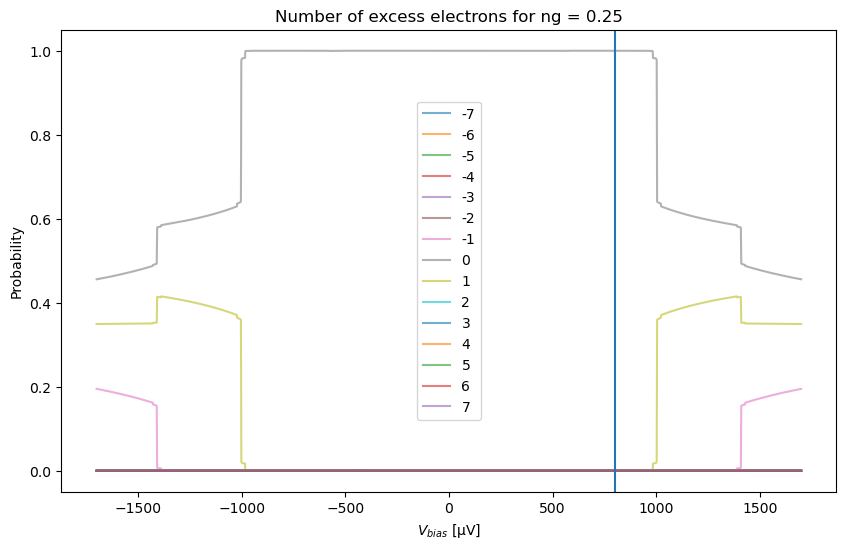

In [103]:
figure(figsize = (10,6))
for i in range(len(ne)):
    plot(v, probn[:,i], alpha = 0.6,label = str(ne[i]))
legend()
title(f'Number of excess electrons for ng = {ng}')
xlabel('$V_{bias}$ [µV]')
ylabel('Probability')
#savefig('Nng0p5.png')
axvline(800)

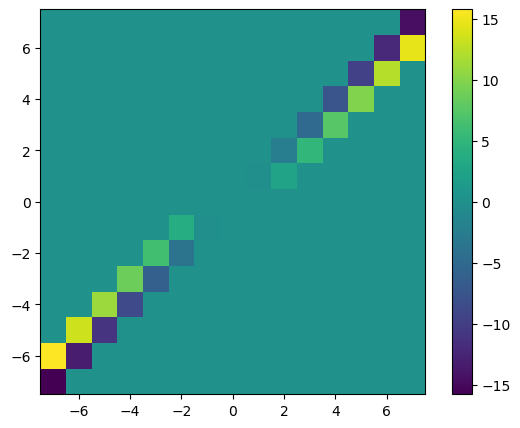

In [104]:
pcolormesh(ne,ne, Gmatrix[1700,:,:])
gca().set_aspect('equal')
colorbar()

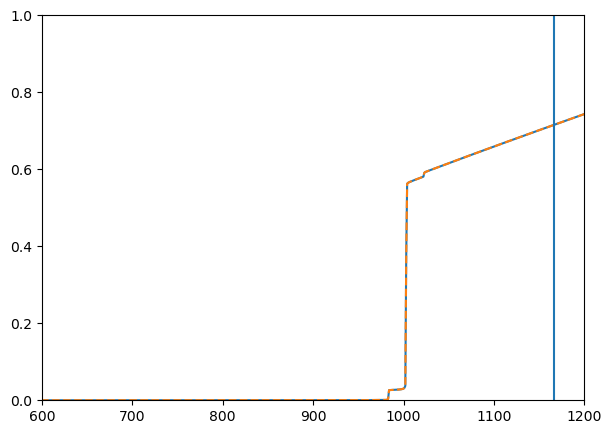

In [105]:
currempty = zeros_like(v)
for i in range(len(v)):
    currempty[i] = -sum(probn[i,:]*curr1junc[i,:])
plot(v, currempty)
czinterp = UnivariateSpline(v, currempty,k=1, s=0)
plot(v, czinterp(v), '--')
xlim(600,1200)
ylim(0,1)
axvline(4*200 + 2*Ec - 2*c.h*f/c.e*1e6)

## P($n_e$, $n_{ph}$) master equation

In [458]:
dyn = 1e-2
deltaAl = 200
Ts = 0.05
Tn = 0.05
Ec = 133
SISISparams = (dyn, deltaAl, Tn, Ts)

In [594]:
%%time
maxe = 3200
de = 0.025
vn = arange(-20, 2*deltaAl-20, 2)
vn2 = arange(2*deltaAl-20, 2*deltaAl+20, 0.05)
varr = r_[arange(-1600, -20, 5), vn, vn2, arange(2*deltaAl+20, 1600, 20)]
ratearr = zeros_like(v, dtype = float)
E = arange(-maxe, maxe, de, dtype=float)
for i in range(len(v)):
    ratearr[i] = trapz(RateSISIS(E,v[i],*SISISparams))*de
Rateinterp = UnivariateSpline(v, ratearr,k=1, s=0)

C:\Users\stanisavljevic\AppData\Local\Temp\ipykernel_17512\204757762.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(exp((E-mu)*c.e*1e-6/c.k/T)+1)


CPU times: total: 1min 55s
Wall time: 1min 55s


In [461]:
Zc = 500
Rk = 25812
λ = sqrt(pi*Zc/Rk)
%time Lag = generateLaguerrearray(30, λ)

CPU times: total: 312 ms
Wall time: 313 ms


In [640]:
phlossrate = 1.5e7*2*pi

def Gsn1phopt(Ec, ne, nph, nphend, ng, v, κ, R, f):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    else:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    return rate

def Gns1phopt(Ec, ne, nph, nphend, ng, v, κ, R, f):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    else:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph,nphend-nph]/c.e*1e-9
    return rate

def Gsn2phopt(Ec, ne, nph, nphend, ng, v, κ, R, f):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    else:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph,nphend-nph]/c.e*1e-9
    return rate

def Gns2phopt(Ec, ne, nph, nphend, ng, v, κ, R, f):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    else:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph,nphend-nph]/c.e*1e-9
    return rate

def Gmphopt(Ec, ne, nph, nphend, ng, v, κ1, κ2, R, f):
    g = Gns1phopt(Ec, ne, nph, nphend, ng, v, κ1, R, f) + Gns2phopt(Ec, ne, nph, nphend, ng, v, κ2, R, f)
    return g

def Gpphopt(Ec, ne, nph, nphend, ng, v, κ1, κ2, R, f):
    g = Gsn1phopt(Ec, ne, nph, nphend, ng, v, κ1, R, f) + Gsn2phopt(Ec, ne, nph, nphend, ng, v, κ2, R, f)
    return g

def Gpphsumopt(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f):
    g = zeros_like(v)
    for kk in range(ntrunc+1):
        g += Gpphopt(Ec, ne, nph, kk, ng, v, κ1, κ2, R, f)
    return g

def Gmphsumopt(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f):
    g = zeros_like(v)
    for kk in range(ntrunc+1):
        g += Gmphopt(Ec, ne, nph, kk, ng, v, κ1, κ2, R, f)
    return g

def Gnsummedresopt(ne, ne2):
    if ne == ne2:
        return - Gmphsumopt(Ec, ne, nph, nphmax, ng, v, κ1, κ2, R, f) - Gpphsumopt(Ec, ne, nph, nphmax, ng, v, κ1, κ2, R, f)
    if ne2 - ne == 1:
        return Gmphsumopt(Ec, ne2, nph, nphmax, ng, v, κ1, κ2, R, f)
    elif ne2 - ne == -1:
        return Gpphsumopt(Ec, ne2, nph, nphmax, ng, v, κ1, κ2, R, f)
    else:
        return 0

def Gmatfixedresopt(nph1, nph2, ne, ne2, nphotontrunc):
    if ne == ne2:
        if nph1 == nph2:
            return - Gmphsumopt(Ec, ne, nph1, nphotontrunc, ng, v, κ1, κ2, R, f) - Gpphsumopt(Ec, ne, nph1, nphotontrunc, ng, v, κ1, κ2, R, f)
        elif nph2 == nph1 - 1:
            return nph1 * phlossrate
        else:
            return 0
    if ne2 - ne == 1:
        return Gmphopt(Ec, ne2, nph1, nph2, ng, v, κ1, κ2, R, f)
    elif ne2 - ne == -1:
        return Gpphopt(Ec, ne2, nph1, nph2, ng, v, κ1, κ2, R, f)
    else:
        return 0

def Gmatfixedresoptnondiag(nph1, nph2, ne, ne2, nphotontrunc):
    if ne == ne2:
        if nph2 == nph1 - 1:
            return nph1* phlossrate
        if nph2 == nph - 2:
            return nph1 * phlossrate ** (1/2)
        #if nph2 == nph - 3:
            #return nph1 * phlossrate / 3
        else:
            return 0
    if ne2 - ne == 1:
        return Gmphopt(Ec, ne2, nph1, nph2, ng, v, κ1, κ2, R, f)
    elif ne2 - ne == -1:
        return Gpphopt(Ec, ne2, nph1, nph2, ng, v, κ1, κ2, R, f)
    else:
        return 0

### Creating a fixed photon number subspaces

In [786]:
v = arange(650,1200,2, float)
ntrunc = 5
eltrunc = 6
phstates = arange(ntrunc+1)
elstates = arange(-eltrunc, eltrunc + 1)
#v = [800.5+2*Ec+4.1*c.h*f/c.e*1e6]
Σ = zeros((len(elstates)*len(phstates),len(elstates)*len(phstates)))
Σ[0] = ones(len(elstates)*len(phstates))
svec = zeros(len(elstates)*len(phstates))
ϵ = 1e-3
svec[0] = ϵ
f = 4.811e9
κ1 = 0.55
κ2 = 0.45
R=700e3
#ng = 0
nglist = linspace(-0.8,0.8, 250)
Ec=80
meanphmap = zeros((len(nglist), len(v)))
pnmmap = zeros((len(nglist), len(v), len(phstates), len(elstates)))

In [983]:
@nb.njit
def Gsn1numba(v, ne, ng, nph, nphend, Ec, κ, R, f):
    if nphend < 0:
        return zeros_like(v)
    elif nph > nphend:
        rate = interp(-(2*Ec*(1/2+(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)), varr, ratearr)*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    else:
        rate = interp(-(2*Ec*(1/2+(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)), varr, ratearr)*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    return (rate)

In [972]:
@nb.njit
def interp_nb(xn, x, y, a):
    return interp(xn-a, x, y)

In [982]:
%%time
vtry = linspace(0,100, 20000)
interp_nb(vtry, varr, ratearr, 10)

CPU times: total: 0 ns
Wall time: 0 ns


array([2.74139729e-09, 2.74385647e-09, 2.74631564e-09, ...,
       2.81517623e-07, 2.81540391e-07, 2.81563159e-07])

In [987]:
%%time
vtry = array([0.58])
#vtry = r_[arange(0,780, 10, float), arange(780,820, 0.02, float), arange(820, 1600, 3, float)]
#for i in range(len(vtry)):
a = Gsn1numba(-vtry, 0, 0, 0, 0, 90.5, 0.5, R, f)

CPU times: total: 0 ns
Wall time: 0 ns


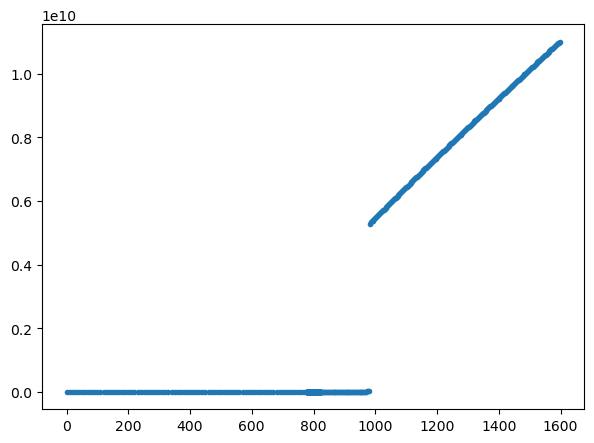

In [708]:
plot(vtry, a, '.')

In [787]:
%%time
for ngi, ng in enumerate(nglist):
    Gmatfr = zeros((len(v), len(elstates), len(elstates),len(phstates), len(phstates)))
    Gtotal = zeros((len(v),len(elstates)*len(phstates),len(elstates)*len(phstates)))
    for ph1 in phstates:
        for ph2 in phstates:
            for i , eli in enumerate(elstates):
                for j, elj in enumerate(elstates):
                    Gmatfr[:, i, j, ph1, ph2] = Gmatfixedresoptnondiag(ph1, ph2, eli, elj, ntrunc)
    for i1 in range(ntrunc+1):
        for i2 in range(ntrunc+1):
            Gtotal[:,i2*len(elstates):(i2+1)*len(elstates),i1*len(elstates):(i1+1)*len(elstates)] = Gmatfr[:,:,:,i1,i2]
    #for kk in range(len(v)):
    for i in range(Gtotal.shape[2]):
        Gtotal[:,i,i] = -sum(Gtotal[:,:,i], axis = 1)
    probn = zeros((len(v),len(elstates)*len(phstates)))
    for i in range(len(v)):
        probn[i,:] = linalg.solve(Gtotal[i] + ϵ*Σ, svec)
        pnm = reshape(probn[i,:], (len(phstates),len(elstates)))
        pnmmap[ngi, i, :, :] = pnm
        meanphmap[ngi, i] = mean(pnm.sum(1)*phstates)

CPU times: total: 42.3 s
Wall time: 42.3 s


 - Checking if the matrix is singular

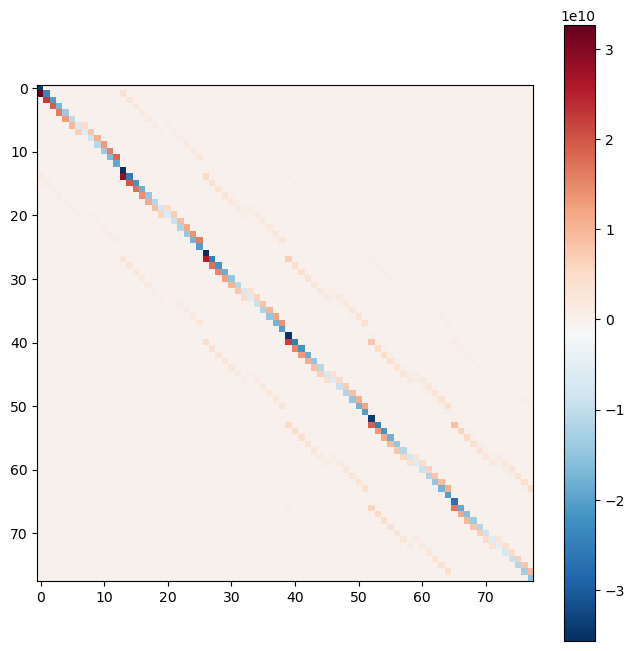

In [661]:
figure(figsize = (8,8))
imshow(Gtotal[100,:,:], cmap = 'RdBu_r')
#gca().set_aspect('equal')
colorbar()

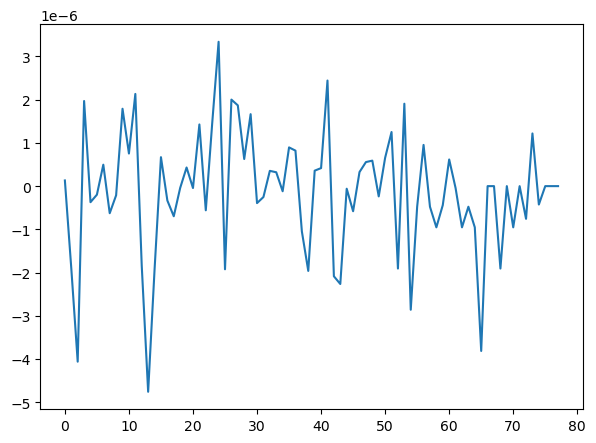

In [520]:
A = Gtotal[100,:,:]
plot(A.sum(0))
#ylim(-1,1)

- Probability for different states as function of bias

(0.0, 1.04)

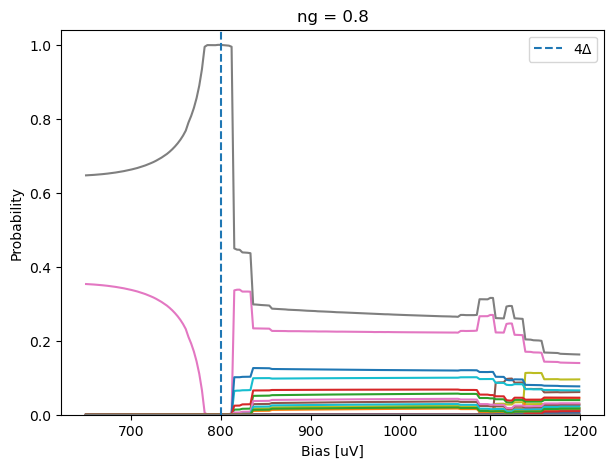

In [522]:
for kk in range(78):
    plot(v, probn[:,kk])
axvline(800, ls = '--', label = '4Δ')
legend()
xlabel('Bias [uV]')
ylabel('Probability')
title('ng = ' + str(nglist[-1]))
ylim(0,1.04)

- Probability map for a given bias and gate

Text(0, 0.5, 'Photon number')

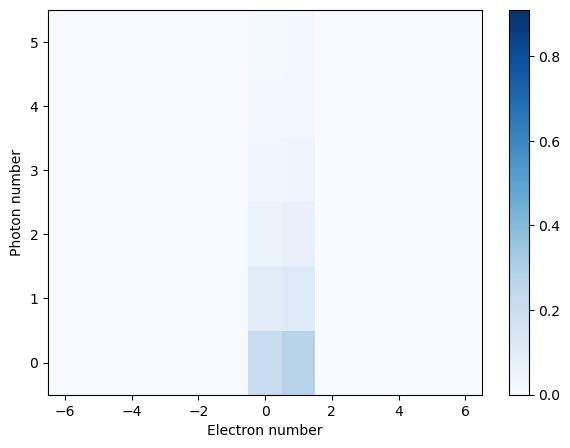

In [530]:
gind = argmin(abs(nglist - 1.5))
vbind = argmin(abs(v - 990))
pcolormesh(elstates, phstates, pnmmap[gind,vbind,:,:], vmax = 0.91, cmap = 'Blues')
colorbar()
xlabel('Electron number')
ylabel('Photon number')

Text(0.5, 1.0, 'Mean photon number as function of gate and bias')

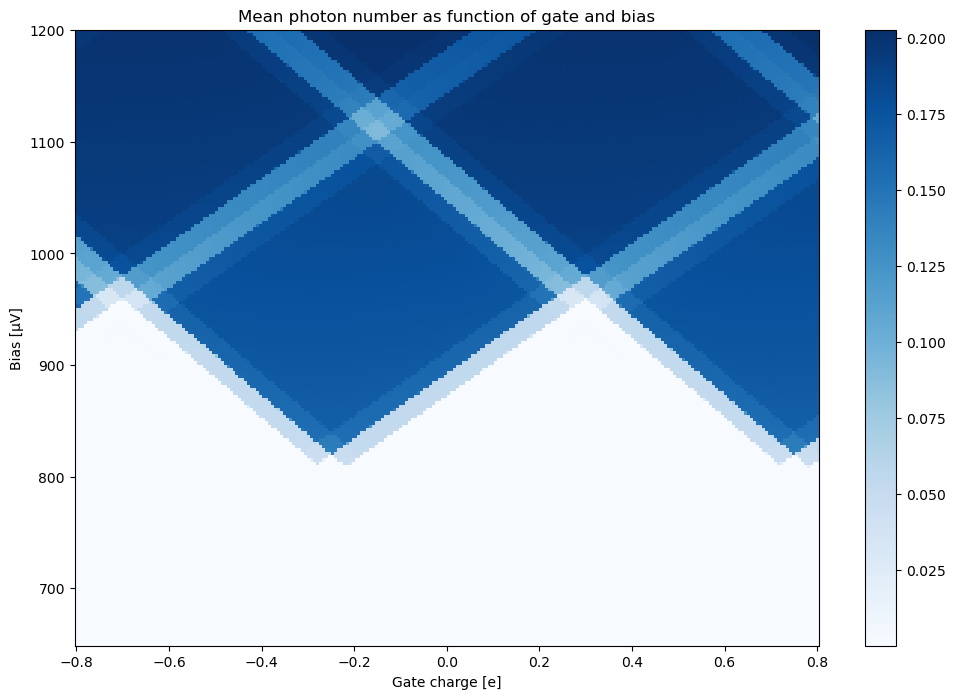

In [531]:
figure(figsize = (12, 8))
pcolormesh(nglist, v, gf(meanphmap.T, (0.02,0.02)), cmap = 'Blues')
colorbar()
ylabel('Bias [µV]')
xlabel('Gate charge [e]')
title('Mean photon number as function of gate and bias')

Text(0, 0.5, 'Mean Photon Number')

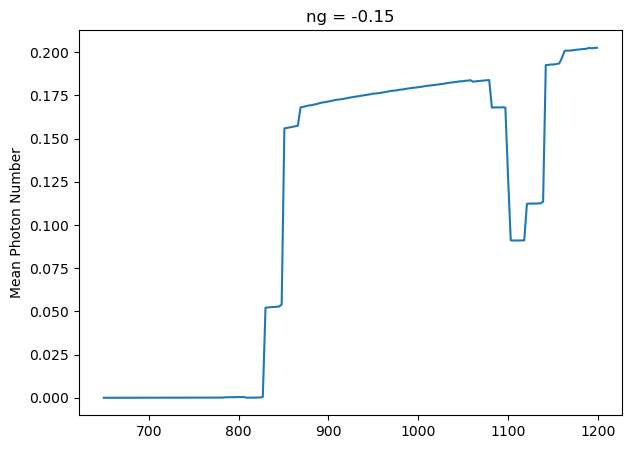

In [533]:
ngind = argmin(abs(nglist + 0.15))
plot(v, meanphmap[ngind,:])
title(f'ng = {nglist[ngind]:.2f}')
ylabel('Mean Photon Number')
#ylim(0.12,0.14)


## Current maps vs bias and gate

In [534]:
currt = zeros((len(nglist), len(v), len(phstates), len(elstates)))
#currt = zeros((len(phstates), len(elstates), len(nglist), len(v)))
for ngind, ng in enumerate(nglist):
    for inp, np in enumerate(phstates): 
        for ie, e in enumerate(elstates):
            for kph in range(ntrunc + 1):
                currt[ngind, :, inp, ie] += -(Gsn1phopt(Ec, e, np, kph, ng, v, κ1, R, f) - Gns1phopt(Ec, e, np, kph, ng, v, κ1, R, f))
adjcurr = currt*pnmmap

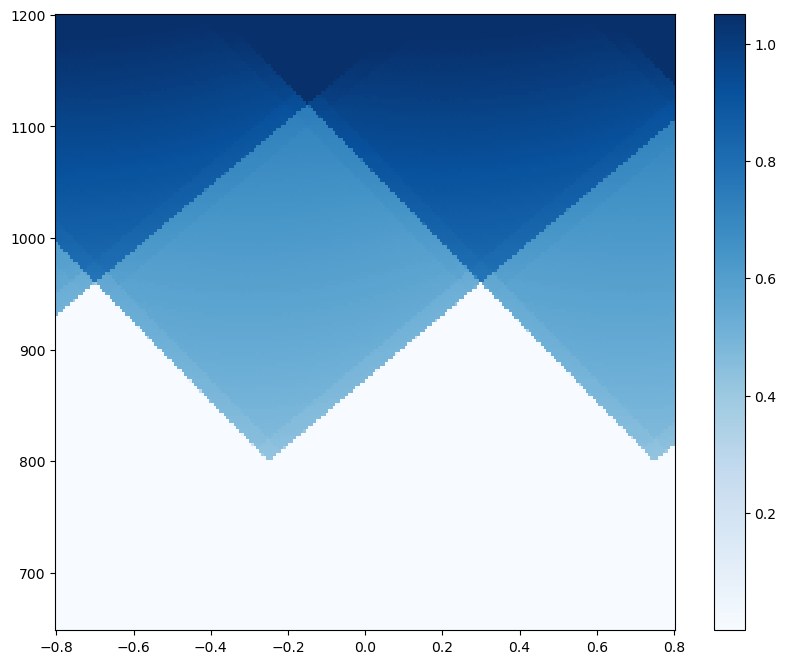

In [537]:
totalcurrent = (adjcurr.sum(3)).sum(2)*c.e
figure(figsize=(10,8))
pcolormesh(nglist, v, (totalcurrent).T*1e9, vmax = 1.05, cmap = 'Blues')
colorbar()

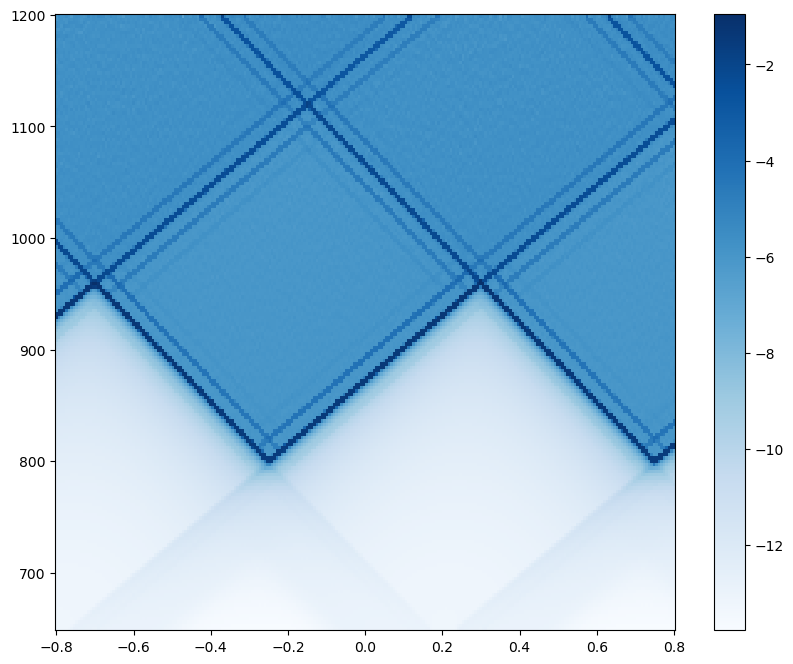

In [538]:
figure(figsize=(10,8))
pcolormesh(nglist, v, log(gradient((totalcurrent).T*1e9, axis = 0)), cmap = 'Blues')
colorbar()

# P($n_e$, $n_{ph}$) master equation with numba

In [458]:
dyn = 1e-2
deltaAl = 200
Ts = 0.05
Tn = 0.05
Ec = 133
SISISparams = (dyn, deltaAl, Tn, Ts)

In [594]:
%%time
maxe = 3200
de = 0.025
vn = arange(-20, 2*deltaAl-20, 2)
vn2 = arange(2*deltaAl-20, 2*deltaAl+20, 0.05)
varr = r_[arange(-1600, -20, 5), vn, vn2, arange(2*deltaAl+20, 1600, 20)]
ratearr = zeros_like(v, dtype = float)
E = arange(-maxe, maxe, de, dtype=float)
for i in range(len(v)):
    ratearr[i] = trapz(RateSISIS(E,v[i],*SISISparams))*de
Rateinterp = UnivariateSpline(v, ratearr,k=1, s=0)

C:\Users\stanisavljevic\AppData\Local\Temp\ipykernel_17512\204757762.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(exp((E-mu)*c.e*1e-6/c.k/T)+1)


CPU times: total: 1min 55s
Wall time: 1min 55s


In [461]:
Zc = 500
Rk = 25812
λ = sqrt(pi*Zc/Rk)
%time Lag = generateLaguerrearray(30, λ)

CPU times: total: 312 ms
Wall time: 313 ms


In [993]:
phlossrate = 1.5e7*2*pi

@nb.njit
def Gsn1numba(v, ne, ng, nph, nphend, Ec, κ, R, f):
    if nphend < 0:
        return zeros_like(v)
    elif nph > nphend:
        rate = interp(-(2*Ec*(1/2+(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)), varr, ratearr)*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    else:
        rate = interp(-(2*Ec*(1/2+(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)), varr, ratearr)*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    return rate

@nb.njit
def Gns1numba(v, ne, ng, nph, nphend, Ec, κ, R, f):
    if nphend < 0:
        return zeros_like(v)
    elif nph > nphend:
        rate = interp(-(2*Ec*(1/2-(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)), varr, ratearr)*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    else:
        rate = interp(-(2*Ec*(1/2-(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)), varr, ratearr)*1e3/((κ)*R)*Lag[nph,nphend-nph]/c.e*1e-9
    return rate

@nb.njit
def Gsn2numba(v, ne, ng, nph, nphend, Ec, κ, R, f):
    if nphend < 0:
        return zeros_like(v)
    elif nph > nphend:
        rate = interp(-(2*Ec*(1/2+(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)), varr, ratearr)*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    else:
        rate = interp(-(2*Ec*(1/2+(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)), varr, ratearr)*1e3/((κ)*R)*Lag[nph,nphend-nph]/c.e*1e-9
    return rate

@nb.njit
def Gns2numba(v, ne, ng, nph, nphend, Ec, κ, R, f):
    if nphend < 0:
        return zeros_like(v)
    elif nph > nphend:
        rate = interp(-(2*Ec*(1/2-(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)), varr, ratearr)*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    else:
        rate = interp(-(2*Ec*(1/2-(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)), varr, ratearr)*1e3/((κ)*R)*Lag[nph,nphend-nph]/c.e*1e-9
    return rate

@nb.njit
def Gmnumba(v, ne, ng, nph, nphend, Ec, κ1, κ2, R, f):
    g = Gns1numba(v, ne, ng, nph, nphend, Ec, κ1, R, f) + Gns2numba(v, ne, ng, nph, nphend, Ec, κ2, R, f)
    return g

@nb.njit
def Gpnumba(v, ne, ng, nph, nphend, Ec, κ1, κ2, R, f):
    g = Gsn1numba(v, ne, ng, nph, nphend, Ec, κ1, R, f) + Gsn2numba(v, ne, ng, nph, nphend, Ec, κ2, R, f)
    return g

@nb.njit
def Gpsumnumba(v, ne, ng, nph, ntrunc, Ec, κ1, κ2, R, f):
    g = 0
    for kk in range(ntrunc+1):
        g += Gpnumba(v, ne, ng, nph, kk, Ec, κ1, κ2, R, f)
    return g

@nb.njit
def Gmsumnumba(v, ne, ng, nph, ntrunc, Ec, κ1, κ2, R, f):
    g = 0
    for kk in range(ntrunc+1):
        g += Gmphopt(v, ne, ng, nph, kk, Ec, κ1, κ2, R, f)
    return g

@nb.njit
def Gmatndnumba(v, nph1, nph2, ne, ne2, nphotontrunc):
    if ne == ne2:
        if nph2 == nph1 - 1:
            return ones_like(v)*nph1* phlossrate
        if nph2 == nph - 2:
            return ones_like(v)*nph1 * phlossrate ** (1/2)
        else:
            return zeros_like(v)
    if ne2 - ne == 1:
        return Gmnumba(v, ne, ng, nph, nph2, Ec, κ1, κ2, R, f)
    elif ne2 - ne == -1:
        return Gpnumba(v, ne, ng, nph, nph2, Ec, κ1, κ2, R, f)
    else:
        return zeros_like(v)

### Creating a fixed photon number subspaces

In [1178]:
v = arange(650,1200,2, float)
ntrunc = 5
eltrunc = 6
phstates = arange(ntrunc+1)
elstates = arange(-eltrunc, eltrunc + 1)
#v = [800.5+2*Ec+4.1*c.h*f/c.e*1e6]
Σ = zeros((len(elstates)*len(phstates),len(elstates)*len(phstates)))
Σ[0] = ones(len(elstates)*len(phstates))
svec = zeros(len(elstates)*len(phstates))
ϵ = 1e-3
svec[0] = ϵ
f = 4.811e9
κ1 = 0.55
κ2 = 0.45
R=700e3
#ng = 0
nglist = linspace(-0.8,0.8, 250)
Ec=80
meanphmap = zeros((len(nglist), len(v)))
pnmmap = zeros((len(nglist), len(v), len(phstates), len(elstates)))

In [1177]:
%time a = populateMatrix(v, 5, 6)

CPU times: total: 0 ns
Wall time: 8.13 ms


In [1183]:
cuc.shape

(275, 78, 78)

In [1210]:
%%time
for k in range(len(nglist)):
    a = addDiag(cuc)

CPU times: total: 8.59 s
Wall time: 1.2 s


In [1206]:
@nb.njit(parallel = True)
def addDiag(Mat):
    fullmat = empty(Mat.shape)
    for i in nb.prange(Mat.shape[2]):
        fullmat[:,i,i] = -sum(Mat[:,:,i], axis = 1)
    return fullmat

In [1234]:
%%time
maptry = getPmap(nglist, v, ntrunc, eltrunc)

CPU times: total: 49.6 s
Wall time: 5.69 s


In [1230]:
@nb.njit(parallel = True)
def getPmap(nglist, v, ntrunc, eltrunc):
    pnmmap = zeros((len(nglist), len(v), len(phstates), len(elstates)))
    for ngi in nb.prange(len(nglist)):
        ng = nglist[ngi]
        Gmat = populateMatrix(v, ntrunc, eltrunc)
        Gnondiag = reshapeMatrix(Gmat, v, ntrunc, eltrunc)
        Gtotal = addDiag(Gnondiag)
        pnmmap[ngi, :, :, :] = GetP(Gtotal, v, ntrunc, eltrunc)
    return pnmmap

In [1215]:
len(v)

275

In [1102]:
@nb.njit(parallel = True)
def populateMatrix(v, ntrunc, eltrunc):
    phstates = arange(ntrunc+1)
    elstates = arange(-eltrunc, eltrunc + 1)
    Gmatfr = zeros((len(v), len(elstates), len(elstates),len(phstates), len(phstates)))
    for ph1 in nb.prange(ntrunc + 1):
        for ph2 in nb.prange(ntrunc + 1):
            for i in range(len(elstates)):
                for j in range(len(elstates)):
                    Gmatfr[:, i, j, ph1, ph2] = Gmatndnumba(v, ph1, ph2, elstates[i], elstates[j], ntrunc)
    return Gmatfr

@nb.njit(parallel = True)
def reshapeMatrix(Mat, v, ntrunc, eltrunc):
    Greshaped = zeros((len(v), (ntrunc + 1)* (2*eltrunc + 1), (ntrunc + 1)* (2*eltrunc + 1)))
    for i1 in nb.prange(ntrunc+1):
        for i2 in range(ntrunc+1):
            Greshaped[:,i2*(2*eltrunc+1):(i2+1)*(2*eltrunc+1),i1*(2*eltrunc+1):(i1+1)*(2*eltrunc+1)] = Mat[:,:,:,i1,i2]
    return Greshaped

In [1156]:
Σ = zeros(((ntrunc+1)*(2*eltrunc+1),(ntrunc+1)*(2*eltrunc+1)))
Σ[0,:] = ones((ntrunc+1)*(2*eltrunc+1))
svec = zeros((ntrunc+1)*(2*eltrunc+1))
ϵ = 1e-3
svec[0] = ϵ

In [1163]:
@nb.njit(parallel = True)
def GetP(RateMat, v, ntrunc, eltrunc):
    probn = zeros((ntrunc+1)*(2*eltrunc+1))
    pnm = zeros((len(v), (ntrunc+1), (2*eltrunc+1)))
    for i in nb.prange(len(v)):
        probn = linalg.solve(RateMat[i,:,:] + ϵ*Σ, svec)
        pnm[i,:,:] = probn.reshape(len(phstates),len(elstates))
    return pnm

In [1173]:
%%time
for a in range(len(nglist)):
    aaa = GetP(Gtotal, v, ntrunc, eltrunc)

CPU times: total: 5.72 s
Wall time: 714 ms


In [1107]:
%%time
for ngi, ng in enumerate(nglist):
    cuc = reshapeMatrix(Gmatfr, v, ntrunc, eltrunc)

CPU times: total: 10.8 s
Wall time: 2.03 s


In [1093]:
%%time
for ngi, ng in enumerate(nglist):
    Gmatfr = populateMatrix(v, ntrunc, eltrunc)
    probn[i,:] = linalg.solve(Gtotal[i] + ϵ*Σ, svec)

CPU times: total: 11.6 s
Wall time: 2.1 s


In [1077]:
%%time
for ngi, ng in enumerate(nglist):
    Gmatfr = populateMatrix(v, ntrunc, eltrunc)
    for i1 in range(ntrunc+1):
        for i2 in range(ntrunc+1):
            Gtotal[:,i2*len(elstates):(i2+1)*len(elstates),i1*len(elstates):(i1+1)*len(elstates)] = Gmatfr[:,:,:,i1,i2]
    for i in range(Gtotal.shape[2]):
        Gtotal[:,i,i] = -sum(Gtotal[:,:,i], axis = 1)
        probn = zeros((len(v),len(elstates)*len(phstates)))
    for i in range(len(v)):
        probn[i,:] = linalg.solve(Gtotal[i] + ϵ*Σ, svec)
        pnm = reshape(probn[i,:], (len(phstates),len(elstates)))
        pnmmap[ngi, i, :, :] = pnm
        meanphmap[ngi, i] = mean(pnm.sum(1)*phstates)

CPU times: total: 24.4 s
Wall time: 15 s


In [1076]:
%%time
for ngi, ng in enumerate(nglist):
    for i in range(Gtotal.shape[2]):
        Gtotal[:,i,i] = -sum(Gtotal[:,:,i], axis = 1)
        probn = zeros((len(v),len(elstates)*len(phstates)))

CPU times: total: 1.88 s
Wall time: 1.87 s


In [1074]:
%%time
for ngi, ng in enumerate(nglist):
    for i in range(len(v)):
        probn[i,:] = linalg.solve(Gtotal[i] + ϵ*Σ, svec)
        pnm = reshape(probn[i,:], (len(phstates),len(elstates)))
        pnmmap[ngi, i, :, :] = pnm
        meanphmap[ngi, i] = mean(pnm.sum(1)*phstates)

CPU times: total: 9.7 s
Wall time: 9.7 s
